# LST trigger studies

## LST trigger architecture

LST camera contains 1855 pixels grouped into 265 modules by 7 pixels in a module. Each module sums the signals from its pixels and shares them with the neighboring modules. Following this, analog sum of three modules is computed for two kinds of 3-module configurations (DAC1 and DAC2) each using its own adder and its own comparator. On the image below, these two configurations are shown. Each hexagon represents a cluster of seven pixels.

![trigger sectors](img/trigger_sectors.png)

Each such 3-module configuration forms a trigger sector. There're 474 trigger sectors in total. Modules, for which it is impossible to form at least one of the trigger sector due to geometrical constraints (border modules) are excluded from the triggering.

In [19]:
#%matplotlib ipympl
#import mpld3
#mpld3.enable_notebook()

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# import block
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from ctapipe.visualization import CameraDisplay
from ctapipe_io_lst import load_camera_geometry
from ctapipe.coordinates import EngineeringCameraFrame
from scipy.interpolate import interp1d
from scipy.integrate import quad

from iact_trigger_tools.utils.plotting import setup_plotting, plot_per_sector_rates
from iact_trigger_tools.utils.fitting import fit_trigger_rate_two_exp, fit_trigger_rate_sum_exp, fit_trigger_rate_one_exp, get_fit_range, mod_exp, sum_exp
from iact_trigger_tools.utils.util import get_module_pixel_map, parse_data_file
from iact_trigger_tools.utils.logger import setup_logging
#from iact_trigger_tools.analysis.ExtractRatesSimulation import extract_rates_from_simulation

# setup block
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
setup_logging()

setup_plotting()

# input files

mapping_file_name = '../inputs/camera_config/camera_CTA-LST.txt'

pulse_shape_file = '../inputs/camera_config/pulse_LST_8dynode_pix6_20200204.dat'

dac_data_files = {'DAC1':'../inputs/data/17Nov2020/scan_l1.2020-11-17-233056.result',
                  'DAC2':'../inputs/data/17Nov2020/scan_l1.2020-11-17-231552.result'}
masked_sectors_files = {'DAC1':'../inputs/data/17Nov2020/modulesNotInTrigger_DAC1.txt',
                        'DAC2':'../inputs/data/17Nov2020/modulesNotInTrigger_DAC2.txt'}

FILE_PATH_MC = '../inputs/simulations'

In [21]:
def parse_dac_file(fname):
    df = pd.DataFrame()
    module_n = -1
    vals_str = ''
    vals = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'Cluster' in line:
                module_n = int(line.split()[1][:-1])
            if 'l1:' in line:
                vals_str = line.split(':')[1]
                vals_str = vals_str.strip()[1:-1]
                vals = [int(v) for v in vals_str.split(',')]
                df[f'{module_n}'] = vals
                
    df['threshold'] = range(0, 251, 2)
    return df

In [22]:
dac_data = {}
mask_data = {}
for label, fname in dac_data_files.items():
    dac_data[label] = parse_dac_file(fname)
    mask_data[label] = list(map(str, np.loadtxt(masked_sectors_files[label], dtype=int).tolist()))

In [23]:
# Retrieve the mapping between pixels and modules

module_to_pixel_map = get_module_pixel_map(mapping_file_name)

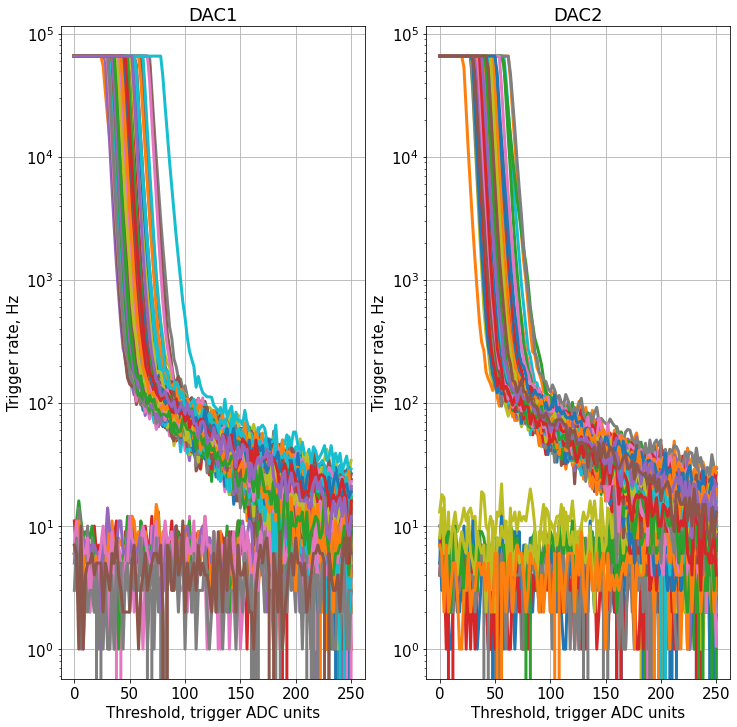

In [24]:
# Plot the trigger rates for all modules
def plot_data_trigger_rate(dac_data, mask_data):
    fig, axes = plt.subplots(1,2)

    for dac_index, ax in zip(dac_data.keys(), axes):
        df = dac_data[dac_index].drop(mask_data[dac_index], axis=1)
        ax.semilogy(df['threshold'], df.drop('threshold', axis=1, inplace=False))
        ax.set_xlabel('Threshold, trigger ADC units')
        ax.set_ylabel('Trigger rate, Hz')
        ax.set_title(dac_index);
        ax.grid(True)

plot_data_trigger_rate(dac_data, mask_data)

As it is evident from the plots above, 
few of the modules are obviously faulty. Add them to the masked modules

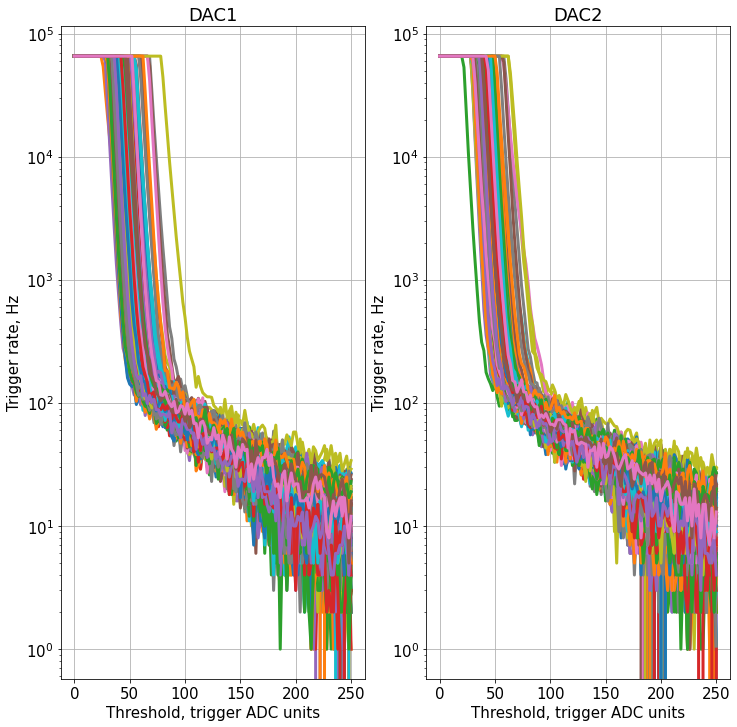

In [25]:
for dac_index in dac_data.keys():
    desc = dac_data[dac_index].drop(mask_data[dac_index], axis=1).describe()
    mask_data[dac_index].extend(list(desc.loc['mean'][desc.loc['mean']<100].index))
plot_data_trigger_rate(dac_data, mask_data)

### Combine all non-excluded data and plot the average trigger rate per module

In [26]:
clean_data = pd.concat([dac_data[dac_index].drop(mask_data[dac_index], axis=1) for dac_index in dac_data.keys()], keys = dac_data.keys(), axis=1)
clean_data.drop(('DAC2', 'threshold'), axis = 1, inplace = True)
clean_data['threshold'] = clean_data['DAC1','threshold']
clean_data.drop(('DAC1', 'threshold'), axis = 1, inplace = True)
clean_data['threshold']

#plot_per_sector_rates(clean_data['threshold'], clean_data.drop('threshold', axis = 1), 'Data', False)

0        0
1        2
2        4
3        6
4        8
      ... 
121    242
122    244
123    246
124    248
125    250
Name: threshold, Length: 126, dtype: int64

In [27]:
def get_fit_results(df, threshold):
    fit_results_tmp = df.apply(fit_trigger_rate_two_exp,
                               axis=0, 
                               result_type='reduce', 
                               args=(threshold,))
    fit_results_df = pd.DataFrame([vals for vals in fit_results_tmp], 
                                  columns=['Intersection',
                                           'NSB slope',
                                           'NSB normalization',
                                           'Proton slope',
                                           'Proton normalization',
                                           'NSB slope error',
                                           'Proton slope error'],
                                  index = fit_results_tmp.keys()) 
    return fit_results_df



In [28]:
fit_results_data = get_fit_results(clean_data.drop('threshold', axis = 1), clean_data['threshold'])


/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow enco

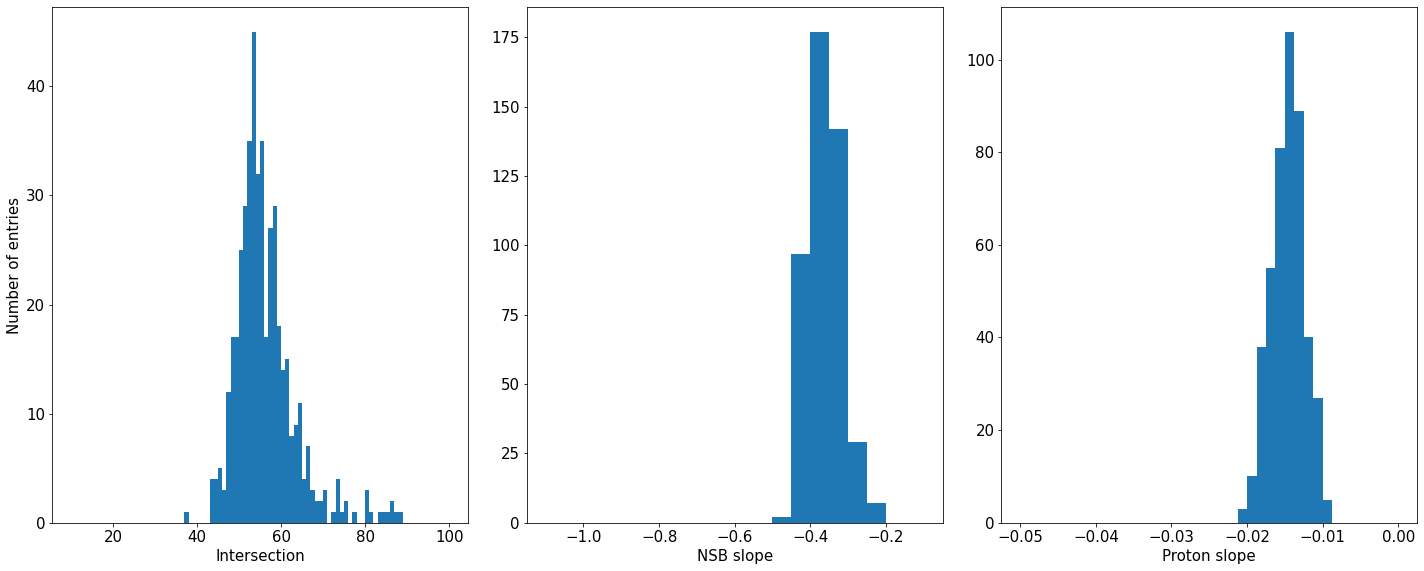

In [29]:
def plot_fit_parameters(df):
    fig, axes = plt.subplots(1,3, figsize=[20,8])
    plt.tight_layout()
    axes[0].hist(df['Intersection'], bins=90, range=(10,100))
    axes[0].set_ylabel("Number of entries")
    axes[0].set_xlabel("Intersection")
    axes[1].hist(df['NSB slope'], bins=20, range=(-1.1,-0.1))
    axes[1].set_xlabel("NSB slope")
    axes[2].hist(df['Proton slope'], bins=40, range=[-0.05,0.0])
    axes[2].set_xlabel("Proton slope")

    
plot_fit_parameters(fit_results_data)

In [30]:
fit_results_data

Intersection  NSB slope  NSB normalization  Proton slope  \
DAC1 2       51.921451   -0.35044           23.01248      -0.01609   
     3       58.148266   -0.30766           22.80350      -0.01854   
     4       61.994788   -0.33801           25.65515      -0.01087   
     5       59.383899   -0.35648           26.06776      -0.01486   
     6       54.346442   -0.37406           25.28378      -0.01615   
...                ...        ...                ...           ...   
DAC2 251     58.595446   -0.33870           24.64212      -0.01159   
     252     57.511536   -0.37887           26.77093      -0.01755   
     253     52.830217   -0.37359           24.54335      -0.01457   
     254     57.943159   -0.31759           23.16901      -0.01164   
     255     60.878269   -0.35906           26.63425      -0.01267   

          Proton normalization  NSB slope error  Proton slope error  
DAC1 2                 5.65264          0.00759             0.00056  
     3                 5.99128          0.01583             0.00076  
     4                 5.37416          0.00440             0.00037  
     5                 5.78078          0.00666             0.00051  
     6                 5.83292          0.00275             0.00056  
...                        ...              ...                 ...  
DAC2 251               5.47492          0.00363             0.00046  
     252               5.99048          0.00292             0.00061  
     253               5.57618          0.00507             0.00054  
     254               5.44128          0.00803             0.00041  
     255               5.54665          0.00215             0.00043  

[454 rows x 7 columns]

In [31]:

fit_results_data_DAC1 = fit_results_data[['DAC1' in s for s in fit_results_data.index]]
fit_results_data_DAC2 = fit_results_data[['DAC2' in s for s in fit_results_data.index]]

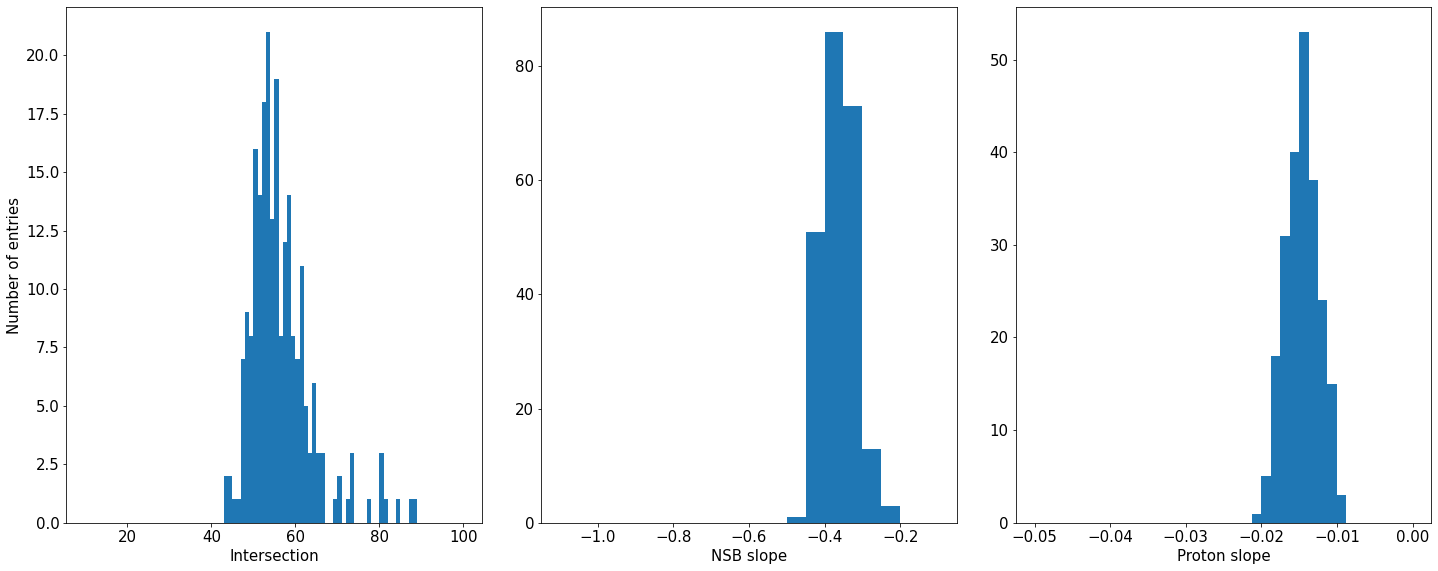

In [32]:
plot_fit_parameters(fit_results_data_DAC1)

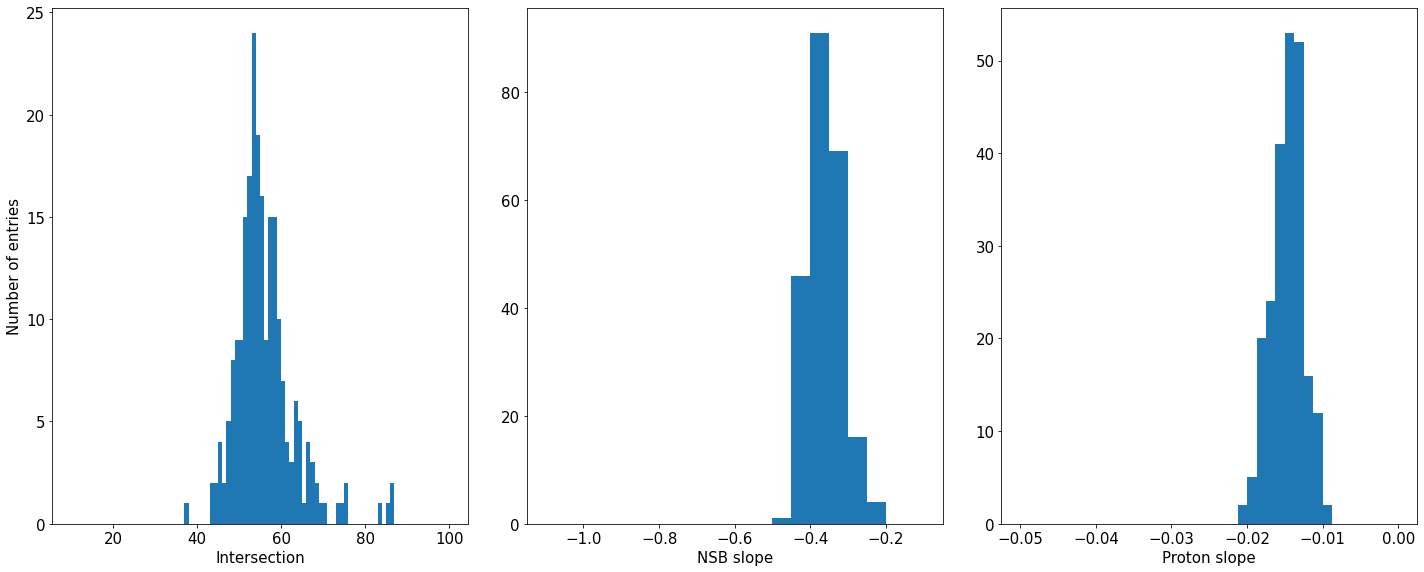

In [33]:
plot_fit_parameters(fit_results_data_DAC2)

In [34]:
def find_nearest(arr, val):
    return arr[(np.abs(arr - val)).argmin()]

def recalibrate(data, intersection_points, central_point=None):
    threshold = data['threshold']
    new_data = pd.DataFrame()
    if central_point is None:
        # calculate mean intersection point
        average_intersection_point = np.mean(intersection_points)
    else:
        average_intersection_point = central_point
    # find nearest to the average intersection value of threshold
    central_threshold = find_nearest(threshold, average_intersection_point)
    central_index = threshold.tolist().index(central_threshold)
    intersections_rounded = [find_nearest(threshold, x) for x in intersection_points]
    intersection_indexes = np.asarray([threshold.tolist().index(x) for x in intersections_rounded])
    indexes_difference = (-1) * (intersection_indexes - central_index)
    #print(indexes_difference)
    for col, shift in zip(data.columns, indexes_difference):
        new_data[col] = np.roll(data[col], shift)
        
    new_data['threshold'] = threshold
    shift_left_max = np.abs(np.min(indexes_difference))
    shift_right_max = np.max(indexes_difference)
    print(f"shift maxes {shift_right_max}, {shift_left_max}")
    new_data[new_data.index < shift_right_max] = None
    new_data[new_data.index > (np.max(new_data.index) - shift_left_max)] = None
    new_data.dropna(inplace=True)
    new_data.reset_index(drop=True, inplace=True)

    return new_data
    
    

In [35]:
average_intersection_point = np.mean(fit_results_data['Intersection'])
self_recalibrated_data = recalibrate(clean_data, fit_results_data['Intersection'], average_intersection_point)

shift maxes 9, 25


2021-11-25 17:11:06,235 - iact_trigger_tools.utils.logger - INFO - Average fit results: (57.84288597214941, -0.32764, 23.77912, -0.01439, 5.65977, 0.01376, 8e-05)
2021-11-25 17:11:06,235 - iact_trigger_tools.utils.logger - INFO - Average fit results: (57.84288597214941, -0.32764, 23.77912, -0.01439, 5.65977, 0.01376, 8e-05)


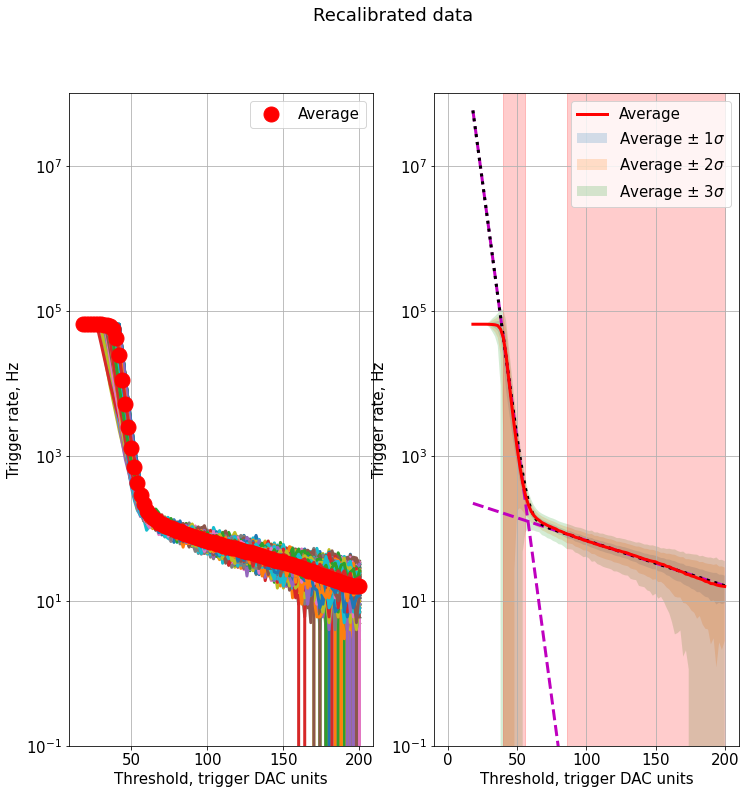

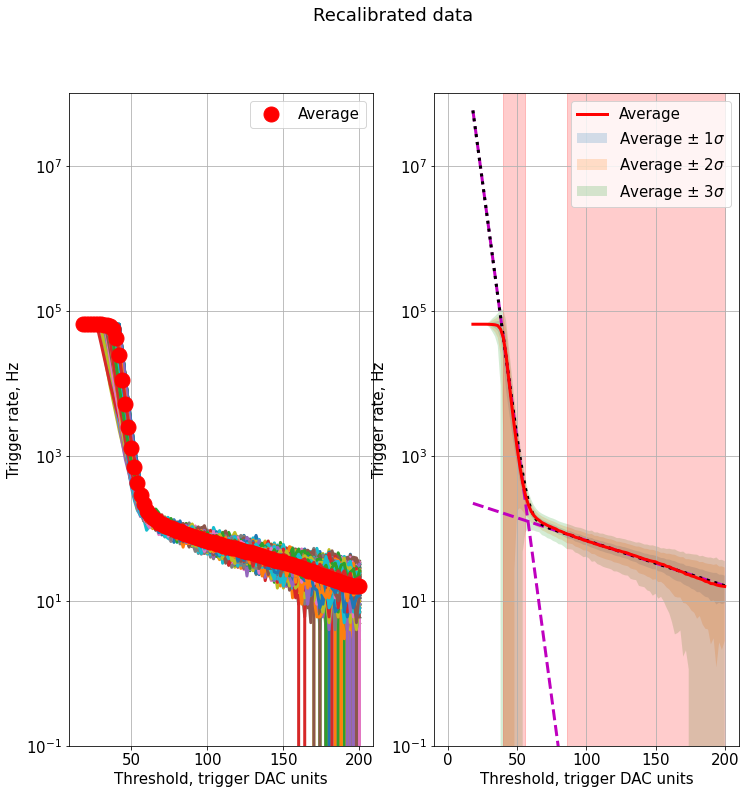

In [36]:
self_recalibrated_data.head(10)
plot_per_sector_rates(self_recalibrated_data['threshold'], self_recalibrated_data.drop('threshold', axis=1, inplace=False), 'Recalibrated data', False)

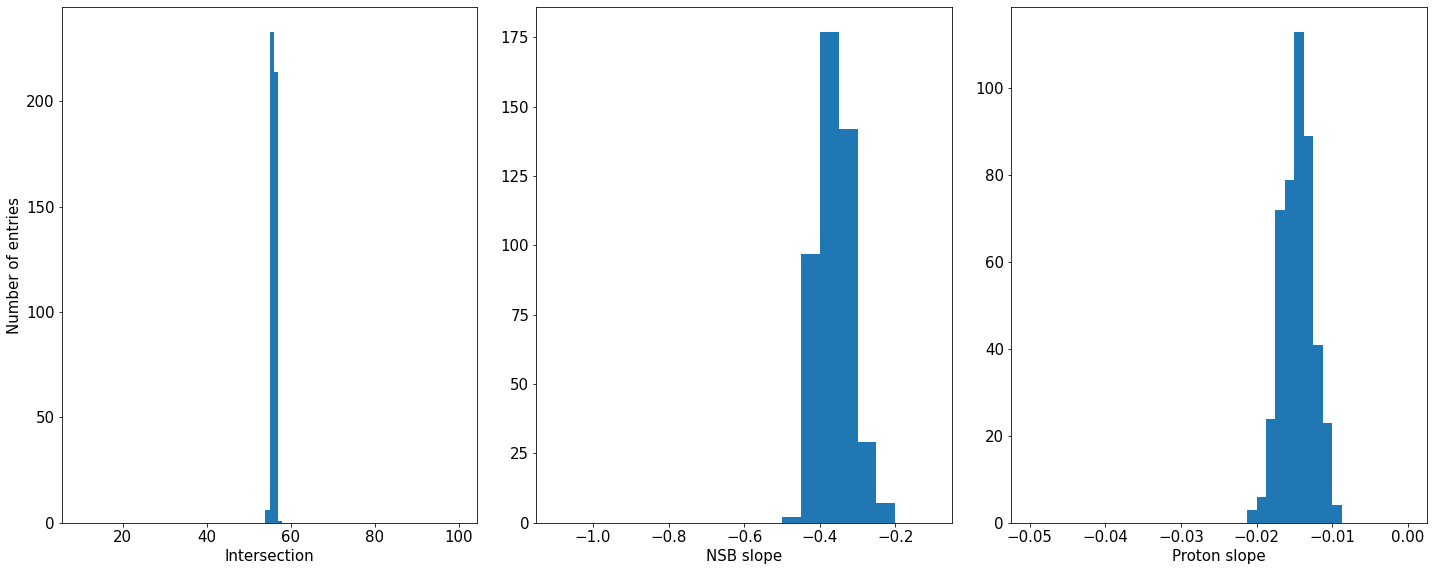

In [37]:
fit_results_recalibrated_data = get_fit_results(self_recalibrated_data.drop('threshold', axis=1, inplace=False),
                                                self_recalibrated_data['threshold'])
plot_fit_parameters(fit_results_recalibrated_data)

## Simulation data format definition

Simulation data is produced with the `sim_telarray` program and follows the `cta` event format definition. This data format is described by `EventIO` and `hessIO` libraries. 
The most interesting part in our case is list of triggered sectors per event. We can compare the average and per-sector rates with the result of the real data scan

In [38]:
nsb_file_csv = '/home/voutsi/Work/Simulation/NSB/mc.csv'

In [39]:
sim_nsb = pd.read_csv(nsb_file_csv)
sim_nsb.drop('Unnamed: 0', axis=1, inplace=True)
sim_nsb.head(5)

nsb rate  threshold  simulated events  triggered events   camera rate  \
0   0.24586         10            100000            100000  1.365333e+07   
1   0.24586         20            100000            100000  1.365333e+07   
2   0.24586         30            100000            100000  1.365333e+07   
3   0.24586         40            100000            100000  1.365333e+07   
4   0.24586         50            100000            100000  1.365333e+07   

   number of fired sectors  trg sct 0 rate  trg sct 1 rate  trg sct 2 rate  \
0                473.96349    1.365251e+07    1.365251e+07    1.365279e+07   
1                472.75630    1.361715e+07    1.361688e+07    1.362220e+07   
2                459.91056    1.323855e+07    1.323281e+07    1.322148e+07   
3                406.53210    1.163523e+07    1.170118e+07    1.168971e+07   
4                300.77503    8.813636e+06    8.663996e+06    8.752469e+06   

   trg sct 3 rate  ...  trg sct 464 rate  trg sct 465 rate  trg sct 466 rate  \
0    1.365265e+07  ...      1.365265e+07      1.365210e+07      1.365292e+07   
1    1.361374e+07  ...      1.361661e+07      1.361811e+07      1.362302e+07   
2    1.323622e+07  ...      1.328142e+07      1.327063e+07      1.328319e+07   
3    1.153242e+07  ...      1.182938e+07      1.186652e+07      1.191335e+07   
4    8.646383e+06  ...      8.699767e+06      8.815957e+06      8.915627e+06   

   trg sct 467 rate  trg sct 468 rate  trg sct 469 rate  trg sct 470 rate  \
0      1.365238e+07      1.365265e+07      1.365210e+07      1.365224e+07   
1      1.361811e+07      1.362275e+07      1.362275e+07      1.361988e+07   
2      1.327978e+07      1.327596e+07      1.328305e+07      1.328852e+07   
3      1.186939e+07      1.182966e+07      1.188045e+07      1.183403e+07   
4      8.898423e+06      8.771311e+06      8.855415e+06      8.910438e+06   

   trg sct 471 rate  trg sct 472 rate  trg sct 473 rate  
0      1.365251e+07      1.365265e+07      1.365183e+07  
1      1.362234e+07      1.362166e+07      1.361975e+07  
2      1.330340e+07      1.324879e+07      1.325274e+07  
3      1.184249e+07      1.176125e+07      1.186447e+07  
4      8.806673e+06      9.072640e+06      8.983484e+06  

[5 rows x 480 columns]

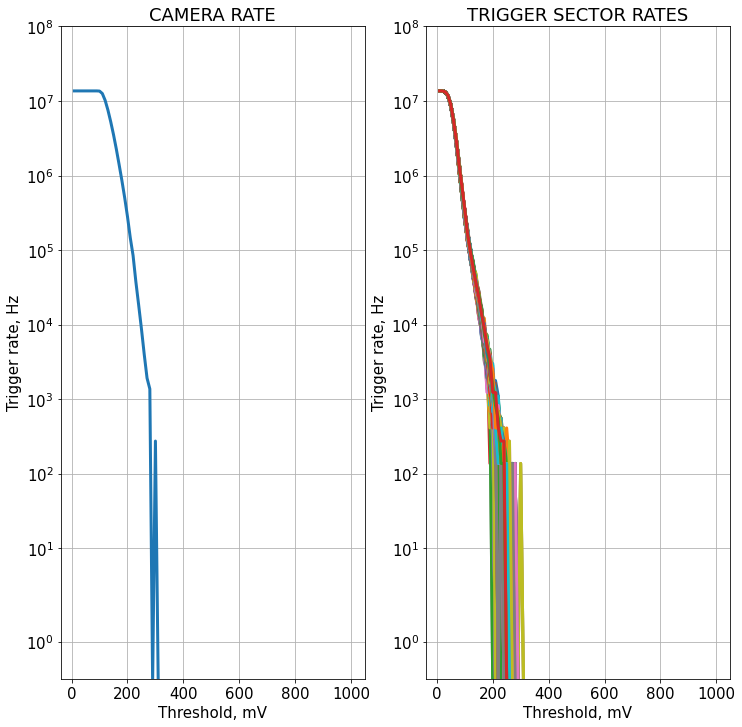

In [40]:
fig, axes = plt.subplots(1,2)

for i, ax in enumerate(axes):
    if i == 0:
        ax.semilogy(sim_nsb['threshold'], sim_nsb['camera rate'])
        ax.set_title('CAMERA RATE');
    else:    
        ax.semilogy(sim_nsb['threshold'], sim_nsb.drop(['nsb rate',
                                              'threshold',
                                              'camera rate',
                                              'simulated events',
                                              'triggered events',
                                              'number of fired sectors'],
                                             axis=1, inplace=False))
        ax.set_title('TRIGGER SECTOR RATES');
    ax.set_xlabel('Threshold, mV')
    ax.set_ylabel('Trigger rate, Hz')
    ax.set_yscale('symlog')
    ax.set_ylim((pow(10,-1),pow(10,8)))
    ax.grid(True)

In [41]:
def interpolate_mc(clean_mc, mc_threshold, data_threshold):
    from scipy import interpolate
    mc_interpolated = pd.DataFrame()
    for col in clean_mc.columns:
        f = interpolate.interp1d(mc_threshold, clean_mc[col])
        mc_interpolated[col] = f(data_threshold)
    return mc_interpolated

In [42]:
def eff_area_from_trigger_probability(trig_prob_file):
    # Calculate the effective area as a function of energy
    with np.load(trig_prob_file, allow_pickle=True) as weights:
        binning = weights['binning']
        trigger_probability = weights['differential_trigger_probability']
        trigger_probability_high = weights['differential_trigger_probability_high']
        trigger_probability_low = weights['differential_trigger_probability_low']
        r = 0.5 * (binning[1][1:] + binning[1][:-1]) # get impact parameter bin centers
        dr = (binning[1][1:] - binning[1][:-1]) # get impact parameter bin widths
        rdr = r * dr
        omega_edges = 2 * np.pi * (1 - np.cos(binning[2]))
        domega = (omega_edges[1:] - omega_edges[:-1]).reshape([1, 1, -1])
        rdr = rdr.reshape([1, -1, 1])
        eff_area = 2 * np.pi * np.sum(trigger_probability * rdr * domega, axis=(1, 2))
        eff_area_err_low = 2 * np.pi * np.sqrt(np.nansum(((trigger_probability - trigger_probability_low) * rdr * domega)**2, axis=(1, 2)))
        eff_area_err_high = 2 * np.pi * np.sqrt(np.nansum(((trigger_probability_high - trigger_probability) * rdr * domega)**2, axis=(1, 2)))
        return eff_area, eff_area_err_low, eff_area_err_high, binning[0]

In [ ]:
# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_soft(energy, func):
    result = (0.0868*pow(energy, -2.6) * pow((1 + pow((energy/13.6),5.0)), -0.05))*func(energy)
    #print("Flux", result, "x", func(energy))
    if result < 0: result = 0
    return result    

In [ ]:
# Import hard DAMPE spectrum (0.1 - 6.3 TeV) for Protons
def DAMPE_hard(energy, func): 
    result = (0.0758*pow(energy, -2.772) * pow((1 + pow((energy/0.48),5.0)), 0.0346))*func(energy)    
    if result < 0: result = 0
    return result 

In [43]:
# Calculating trigger rates taking into account the hardening at few hundreds GeV and the softening after 10 TeV of the spectrum as observed by DAMPE.
# The two regions were fitted with a SBPL
def rate_from_diff_trig_prob_DAMPE(probfile):
    ea, eal, eah, energy_binning = eff_area_from_trigger_probability(probfile)
    #print('effective area',ea,'eal',eal,'eah',eah)
    #print("eal", eal)
    #print('length',len(eal))
    #print("eah", eah)    
    bin_centers = 0.5 * (energy_binning[1:] + energy_binning[:-1])
    eff_area_interpolated = interp1d(bin_centers, ea, fill_value='extrapolate')
    eff_area_interpolated_low = interp1d(bin_centers, ea-eal, fill_value='extrapolate')
    eff_area_interpolated_high = interp1d(bin_centers, ea+eah, fill_value='extrapolate')

    # rate from pyirf spectrum law, 10 GeV < E < 100 GeV
    rate_pl, err = quad(differential_rate, 0.01, 0.1, args=(eff_area_interpolated), limit=100)
    rate_pl_low, err = quad(differential_rate, 0.01, 0.1, args=(eff_area_interpolated_low), limit=100)
    rate_pl_high, err = quad(differential_rate, 0.01, 0.1, args=(eff_area_interpolated_high), limit=100)
    
    # rate from DAMPE SBPL soft, 100 GeV < E < 6.3 TeV    
    rate_soft, err = quad(DAMPE_hard, 0.1, 6.3, args=(eff_area_interpolated), limit=100)
    rate_soft_low, err = quad(DAMPE_hard, 0.1, 6.3, args=(eff_area_interpolated_low), limit=100)
    rate_soft_high, err = quad(DAMPE_ahard, 0.1, 6.3, args=(eff_area_interpolated_high), limit=100)    

    # rate from DAMPE SBPL hard, 6.3 TeV < E < 100 TeV        
    rate_hard, err = quad(DAMPE_soft, 6.3, 100, args=(eff_area_interpolated), limit=100)
    rate_hard_low, err = quad(DAMPE_soft, 6.3, 100, args=(eff_area_interpolated_low), limit=100)
    rate_hard_high, err = quad(DAMPE_soft, 6.3, 100, args=(eff_area_interpolated_high), limit=100)    

    rate = rate_pl + rate_soft + rate_hard
    rate_low = rate_pl_low + rate_pl_low + rate_hard_low
    rate_high = rate_pl_high + rate_soft_high + rate_hard_high
    
    return rate, rate_low, rate_high


In [44]:
def differential_rate(energy, func):
    result = 0.096*pow(energy, -2.7)*func(energy)
    if result < 0: result = 0
    return result

def rate_from_diff_trig_prob(probfile):
    ea, eal, eah, energy_binning = eff_area_from_trigger_probability(probfile)
    bin_centers = 0.5 * (energy_binning[1:] + energy_binning[:-1])
    eff_area_interpolated = interp1d(bin_centers, ea, fill_value='extrapolate')
    eff_area_interpolated_low = interp1d(bin_centers, ea-eal, fill_value='extrapolate')
    eff_area_interpolated_high = interp1d(bin_centers, ea+eah, fill_value='extrapolate')
    rate, err = quad(differential_rate, 0.01, 100, args=(eff_area_interpolated), limit=100)
    rate_low, err = quad(differential_rate, 0.01, 100, args=(eff_area_interpolated_low), limit=100)
    rate_high, err = quad(differential_rate, 0.01, 100, args=(eff_area_interpolated_high), limit=100)
    return rate, rate_low, rate_high

In [45]:
import glob
data = []
for filename in glob.glob('/home/voutsi/Work/ConfMeetings/LST_General_meeting_Nov2021/Work/data/EffectiveAreas/Proton/*.npz'):
    threshold = int(filename.split('_')[-1][:-4])
    rate, rate_low, rate_high = rate_from_diff_trig_prob(filename)
    data.append({'threshold': threshold, 'rate': rate, 'rate_low': rate_low, 'rate_high': rate_high})
sim_camera_rates = pd.DataFrame.from_records(data)
sim_camera_rates.head()

/tmp/ipykernel_23175/3768478198.py:12: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rate, err = quad(differential_rate, 0.01, 100, args=(eff_area_interpolated), limit=100)
/tmp/ipykernel_23175/3768478198.py:13: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the in

threshold          rate      rate_low     rate_high
0        470   2738.134624   2527.936811   3259.002725
1        800   1495.125788   1342.764467   1817.272022
2        490   2631.633465   2421.705711   3139.628980
3         90  23980.355648  23190.233073  26581.040064
4        180   9057.923411   8634.776099  10289.819789

(0.1, 10000000)

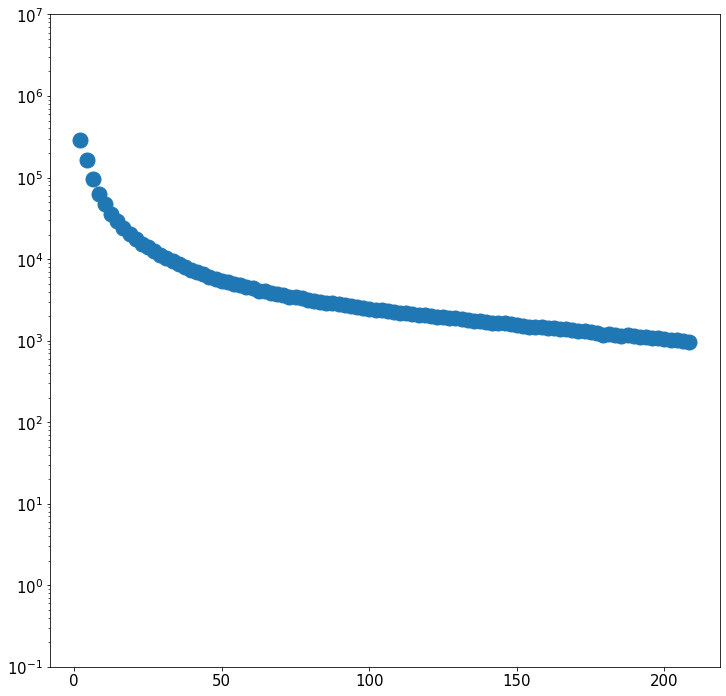

In [46]:
thresholds = []
rates = []
points = []
for i in sorted(glob.glob(f'/home/voutsi/tmp/threshold_rates/rate_threshold*.txt')):
    with open(i, 'r') as f:
        vals = f.readline().split(' ')
        thresholds.append(int(vals[1][:-1])/4.8)
        rates.append(float(vals[4]))
        points.append((int(vals[1][:-1])/4.8, float(vals[4])))

#plt.plot(thresholds, rates, 'bo', linestyle='None', markersize = 3.0)
plt.scatter(*zip(*points))
plt.yscale('log')
plt.ylim(0.1, 10**7)

In [47]:
def plot_fit_parameters_with_overlay(df, intersection, nsb_slope, proton_slope, nsb_slope_err, proton_slope_err):
    fig, axes = plt.subplots(1,3, figsize=[20,8])
    plt.tight_layout()
    axes[0].hist(df['Intersection'], bins=45, range=(10,100))
    axes[0].axvline(x=intersection, color='r', linestyle='-', label='Average MC')
    axes[0].set_ylabel("Number of entries")
    axes[0].set_xlabel("Intersection")
    axes[1].hist(df['NSB slope'], bins=20, range=(-1.1,-0.1))
    axes[1].axvline(x=nsb_slope, color='r', linestyle='-', label='Average MC')
    axes[1].axvspan(nsb_slope-nsb_slope_err, nsb_slope+nsb_slope_err, alpha=0.2, color='green')
    axes[1].set_xlabel("NSB slope")
    axes[2].hist(df['Proton slope'], bins=40, range=[-0.05,0.0])
    axes[2].axvline(x=proton_slope, color='r', linestyle='-', label='Average MC')
    axes[2].axvspan(proton_slope-proton_slope_err, proton_slope+proton_slope_err, alpha=0.2, color='green')
    axes[2].set_xlabel("Proton slope")
    for ax in axes:
        ax.legend()
    
#plot_fit_parameters_with_overlay(fit_results_recalibrated_data, 51.487575396574854, -0.25246,  -0.01097, 0.00183, 0.00035)
#50.40457730454599, -0.25007, 17.6727, -0.01242, 5.69416, 0.00137, 0.00019
#plot_fit_parameters_with_overlay(fit_results_recalibrated_data, 50.40457730454599,  -0.25007, -0.01242,  0.00137, 0.00019)

In [48]:
def overlay_rates_data_mc(threshold, clean_data, clean_mc, title):
    sector_average_data = clean_data.mean(axis=1)
    sector_average_mc = clean_mc.mean(axis=1)

    std_deviation = clean_data.std(axis=1)

    fit_results_data = fit_trigger_rate_two_exp(sector_average_data, threshold)
    fit_results_mc = fit_trigger_rate_two_exp(sector_average_mc, threshold)

    fig, ax = plt.subplots(1,1)
    # plot trigger rates for each module and their average
    ax.semilogy(threshold, sector_average_data, marker='1', label = "Data")
    ax.semilogy(threshold, sector_average_mc, marker='2', label = "Simulation")
   
    ax.semilogy(threshold, sum_exp(threshold, *fit_results_data[1:5]),
                         'k:', "Fit to data")
    ax.semilogy(threshold, sum_exp(threshold, *fit_results_mc[1:5]),
                         'm:', "Fit to simulation")
    for factor in range(1,4):
        ax.fill_between(threshold,
                        sector_average_data - factor * std_deviation,
                        sector_average_data + factor * std_deviation,
                        alpha=0.2, label = f'Data $\pm$ {factor}$\sigma$')
        
    ax.set_xlabel('Threshold, trigger ADC units')
    ax.set_ylabel('Trigger rate, Hz')
    ax.set_ylim((pow(10,-1),pow(10,8)))
    ax.grid(True)
    ax.legend()

    fig.suptitle(title)
    plt.show()


In [49]:
nsb_camera_rate = sim_nsb['camera rate']

In [50]:
sim_camera_rates=sim_camera_rates.sort_values('threshold')
sim_proton_camera_rate = sim_camera_rates['rate']
sim_proton_camera_rate_high = sim_camera_rates['rate_high']
sim_proton_camera_rate_low = sim_camera_rates['rate_low']


len(sim_proton_camera_rate)

100

In [51]:
total_mc_camera_rate = [n + p * 1.5 for n, p in zip(nsb_camera_rate, sim_proton_camera_rate)]
total_mc_camera_rate_high = [n + p * 1.5 for n, p in zip(nsb_camera_rate, sim_proton_camera_rate_high)]
total_mc_camera_rate_low = [n + p * 1.5 for n, p in zip(nsb_camera_rate, sim_proton_camera_rate_low)]




(0.1, 100000000)

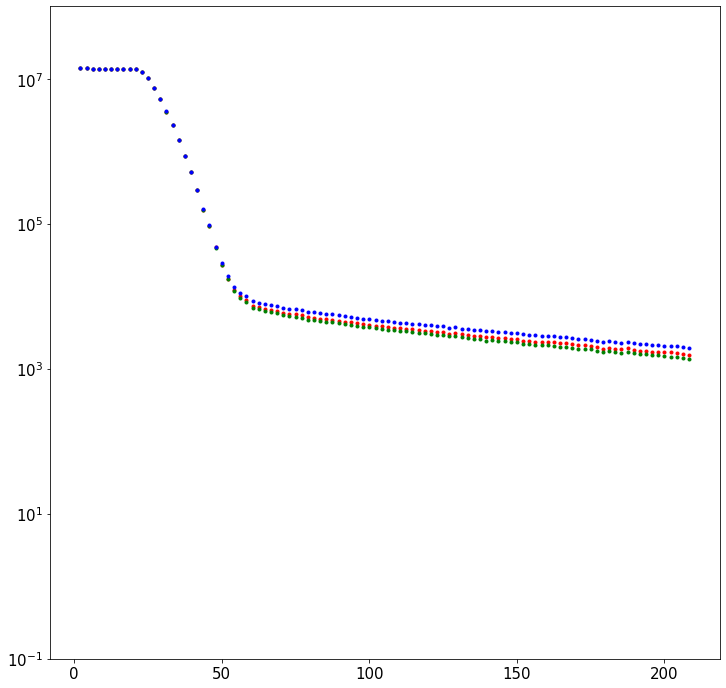

In [52]:
#thresholds = df_rates['threshold']

thresholds = [v[0] for v in sorted(points)]

plt.plot(sorted(thresholds), total_mc_camera_rate, 'ro', linestyle='None', markersize = 3.0)
plt.plot(sorted(thresholds), total_mc_camera_rate_low, 'go', linestyle='None', markersize = 3.0)
plt.plot(sorted(thresholds), total_mc_camera_rate_high, 'bo', linestyle='None', markersize = 3.0)
plt.yscale('log')
plt.ylim(0.1, 10**8)

In [53]:
thresholds = []
rates = []
points = []
lines = []
for i in sorted(glob.glob(f'/home/voutsi/Work/ConfMeetings/LST_General_meeting_Nov2021/Work/data/PerSector/Helium/rate_per_sector_threshold_*.txt')):
    with open(i, 'r') as f:
        content = f.read().splitlines()
        threshold = int(content[0].split(' ')[1])/4.8
        camera_triggered = int(content[1].split(' ')[2])
        average_sector_triggered = float(content[2].split(' ')[3])
        sigma_sector_triggered = float(content[3].split(' ')[3])
        relative_sector_rate = average_sector_triggered/camera_triggered
        relative_sector_rate_up = (average_sector_triggered + sigma_sector_triggered)/camera_triggered
        relative_sector_rate_down = (average_sector_triggered - sigma_sector_triggered)/camera_triggered
        lines.append([threshold,
                      camera_triggered,
                      average_sector_triggered,
                      sigma_sector_triggered,
                      relative_sector_rate,
                      relative_sector_rate_up,
                      relative_sector_rate_down])
                
sim_proton_sector_df = pd.DataFrame(lines, columns = ['threshold',
                                                  'Camera triggered',
                                                  'Average sector triggered',
                                                  'Sigma sector triggered',
                                                  'Relative sector rate',
                                                  'Relative sector rate up',
                                                  'Relative sector rate down'])
sim_proton_sector_df.sort_values(by='threshold', inplace=True)
sim_proton_sector_df.head()
#plt.plot(thresholds, rates, 'bo', linestyle='None', markersize = 3.0)
#plt.scatter(*zip(*points))
#plt.yscale('log')
#plt.ylim(0.1, 10**7)

threshold  Camera triggered  Average sector triggered  \
0    2.083333             73281               2738.094937   
12   4.166667             43986               1347.219409   
23   6.250000             28013                826.742616   
34   8.333333             19857                582.531646   
45  10.416667             15103                444.584388   

    Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0                91.201644              0.037364                 0.038609   
12               47.326302              0.030628                 0.031704   
23               34.525860              0.029513                 0.030745   
34               24.133508              0.029336                 0.030552   
45               21.262630              0.029437                 0.030845   

    Relative sector rate down  
0                    0.036120  
12                   0.029552  
23                   0.028280  
34                   0.028121  
45                   0.028029

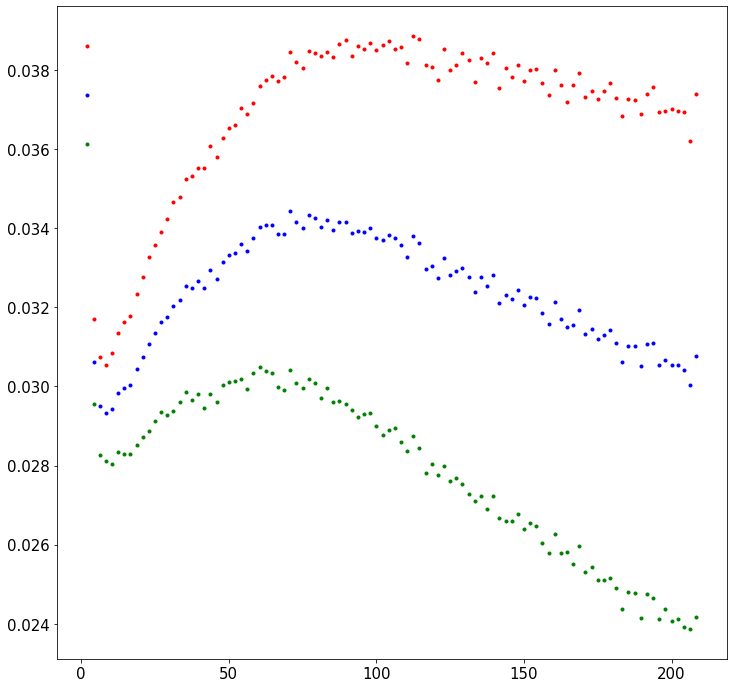

In [54]:
plt.plot(sim_proton_sector_df['threshold'], sim_proton_sector_df['Relative sector rate'], 'bo', linestyle='None', markersize = 3.0)
plt.plot(sim_proton_sector_df['threshold'], sim_proton_sector_df['Relative sector rate up'], 'ro', linestyle='None', markersize = 3.0)
plt.plot(sim_proton_sector_df['threshold'], sim_proton_sector_df['Relative sector rate down'], 'go', linestyle='None', markersize = 3.0)


#plt.scatter(*zip(*points))
#plt.yscale('log')
#plt.ylim(0.1, 10**7)

In [55]:
def error_propagation(a, b, aprime, bprime):
    da = aprime - a
    db = bprime - b
    d_ab = np.sqrt(pow(da/a, 2) + pow(db/b, 2))
    return d_ab 
    
    

In [56]:
sim_proton_camera_sector_rate = [a * b for a,b in zip(sim_proton_camera_rate, 
                                                      sim_proton_sector_df['Relative sector rate'])]
sim_proton_camera_sector_rate_error_high = error_propagation(sim_proton_camera_rate,
                                                             sim_proton_sector_df['Relative sector rate'],
                                                             sim_proton_camera_rate_high, 
                                                             sim_proton_sector_df['Relative sector rate up'])
sim_proton_camera_sector_rate_error_low = error_propagation(sim_proton_camera_rate,
                                                            sim_proton_sector_df['Relative sector rate'],
                                                            sim_proton_camera_rate_low, 
                                                            sim_proton_sector_df['Relative sector rate down'])
sim_proton_camera_sector_rate_up = [a * b * (1+err) for a,b,err in zip(sim_proton_camera_rate, sim_proton_sector_df['Relative sector rate up'], sim_proton_camera_sector_rate_error_high)]
sim_proton_camera_sector_rate_down = [a * b * (1-err) for a,b,err in zip(sim_proton_camera_rate, sim_proton_sector_df['Relative sector rate down'], sim_proton_camera_sector_rate_error_low)]


(0.1, 100000000)

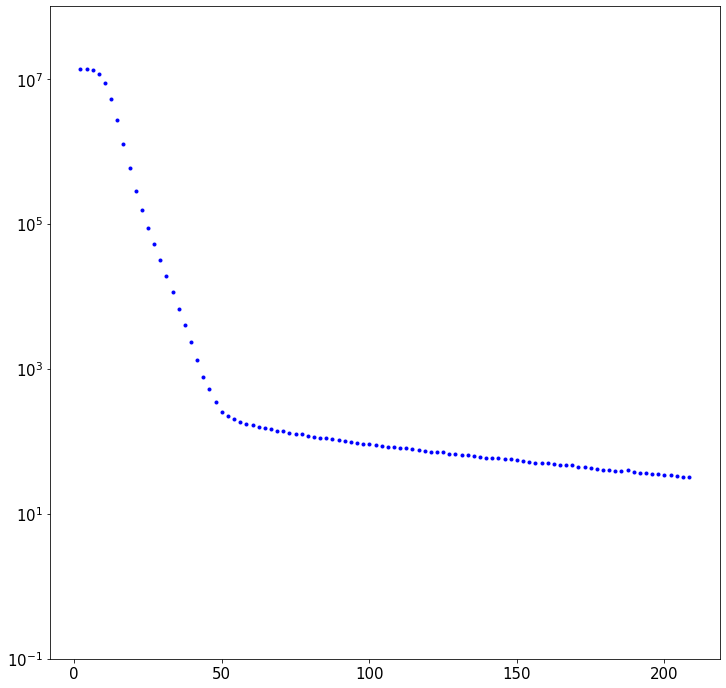

In [57]:
sim_nsb_sector_rates = sim_nsb.drop(['nsb rate',
                                     'threshold',
                                     'camera rate',
                                     'simulated events',
                                     'triggered events',
                                     'number of fired sectors'],
                                    axis=1, inplace=False)
average_nsb_sector = sim_nsb_sector_rates.mean(axis=1)

total_per_sector_rate_mc = [n + p for n, p in zip(average_nsb_sector, sim_proton_camera_sector_rate)]
plt.plot(sim_proton_sector_df['threshold'], total_per_sector_rate_mc, 'bo', linestyle='None', markersize = 3.0)
plt.yscale('log')
plt.ylim(0.1, 10**8)

In [58]:
data_average = self_recalibrated_data.drop('threshold', axis=1, inplace=False).mean(axis=1)
self_recalibrated_data.head(5)

(DAC1, 2)  (DAC1, 3)  (DAC1, 4)  (DAC1, 5)  (DAC1, 6)  (DAC1, 7)  \
0    65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
1    65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
2    65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
3    65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
4    65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   

   (DAC1, 10)  (DAC1, 11)  (DAC1, 12)  (DAC1, 13)  ...  (DAC2, 244)  \
0     65535.0     65535.0     65535.0     65535.0  ...      65535.0   
1     65535.0     65535.0     65535.0     65535.0  ...      65535.0   
2     65535.0     65535.0     65535.0     65535.0  ...      65535.0   
3     65535.0     65535.0     65535.0     65535.0  ...      65535.0   
4     65535.0     65535.0     65535.0     65535.0  ...      65535.0   

   (DAC2, 245)  (DAC2, 249)  (DAC2, 250)  (DAC2, 251)  (DAC2, 252)  \
0      65535.0      65535.0      65535.0      65535.0      65535.0   
1      65535.0      65535.0      65535.0      65535.0      65535.0   
2      65535.0      65535.0      65535.0      65535.0      65535.0   
3      65535.0      65535.0      65535.0      65535.0      65535.0   
4      65535.0      65535.0      65535.0      65535.0      65535.0   

   (DAC2, 253)  (DAC2, 254)  (DAC2, 255)  threshold  
0      65535.0      65535.0      65535.0       18.0  
1      65535.0      65535.0      65535.0       20.0  
2      65535.0      65535.0      65535.0       22.0  
3      65535.0      65535.0      65535.0       24.0  
4      65535.0      65535.0      65535.0       26.0  

[5 rows x 455 columns]

(0.1, 100000000)

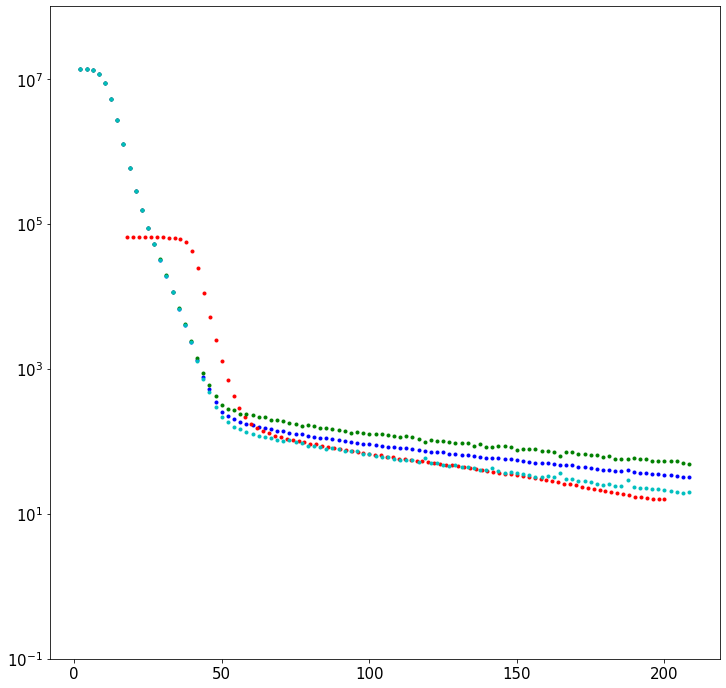

In [59]:
plt.plot(sim_proton_sector_df['threshold'], total_per_sector_rate_mc, 'bo', linestyle='None', markersize = 3.0)
plt.plot(self_recalibrated_data['threshold'], data_average, 'ro', linestyle='None', markersize = 3.0)
total_per_sector_rate_mc_up = [n + p for n, p in zip(average_nsb_sector, sim_proton_camera_sector_rate_up)]
total_per_sector_rate_mc_down = [n + p for n, p in zip(average_nsb_sector, sim_proton_camera_sector_rate_down)]
plt.plot(sim_proton_sector_df['threshold'], total_per_sector_rate_mc_up, 'go', linestyle='None', markersize = 3.0)
plt.plot(sim_proton_sector_df['threshold'], total_per_sector_rate_mc_down, 'co', linestyle='None', markersize = 3.0)


plt.yscale('log')
plt.ylim(0.1, 10**8)

In [60]:
def plot_per_sector_rates_1(threshold, sector_average, sector_average_high, sector_average_low, title):
    from lst_trigger import get_fit_range, mod_exp, sum_exp

    fit_results = fit_trigger_rate_two_exp(sector_average, threshold)
    print('Average fit results: ', fit_results)

    low, high = get_fit_range(threshold, sector_average)

    fig, axes = plt.subplots(1, 2)
    # plot trigger rates for each module and their average
    axes[0].semilogy(threshold, sector_average, "ro", label="Average")
    # plot average trigger rate with 1,2,3 std deviation bands
    
    axes[1].semilogy(threshold, mod_exp(threshold, *fit_results[1:3]),
                         'm--', "Fit of average, fast")
    axes[1].semilogy(threshold, mod_exp(threshold, *fit_results[3:5]),
                         'm--', "Fit of averagei, slow")
    axes[1].semilogy(threshold, sum_exp(threshold, *fit_results[1:5]),
                         'k:', "Sum of two separate exponents")
    axes[1].semilogy(threshold, sector_average, "r-", label="Average")
    #axes[1].axvspan(threshold[low], threshold[high], alpha=0.2, color='red')
    #axes[1].axvspan(threshold[high+15], threshold[len(threshold)-1], alpha=0.2, color='red')
    axes[1].fill_between(threshold,
                        sector_average_low,
                        sector_average_high,
                        alpha=0.2, label='68% Confidence Interval')

    for ax in axes:
        ax.set_xlabel('Threshold, ADC units')
        ax.set_ylabel('Trigger rate, Hz')
        ax.set_ylim((pow(10, -1), pow(10, 8)))
        ax.grid(True)
        ax.legend()

    fig.suptitle(title)
    plt.show()


Average fit results:  (48.49753705304467, -0.28704, 18.98344, -0.0104, 5.56703, 0.00791, 0.0001)


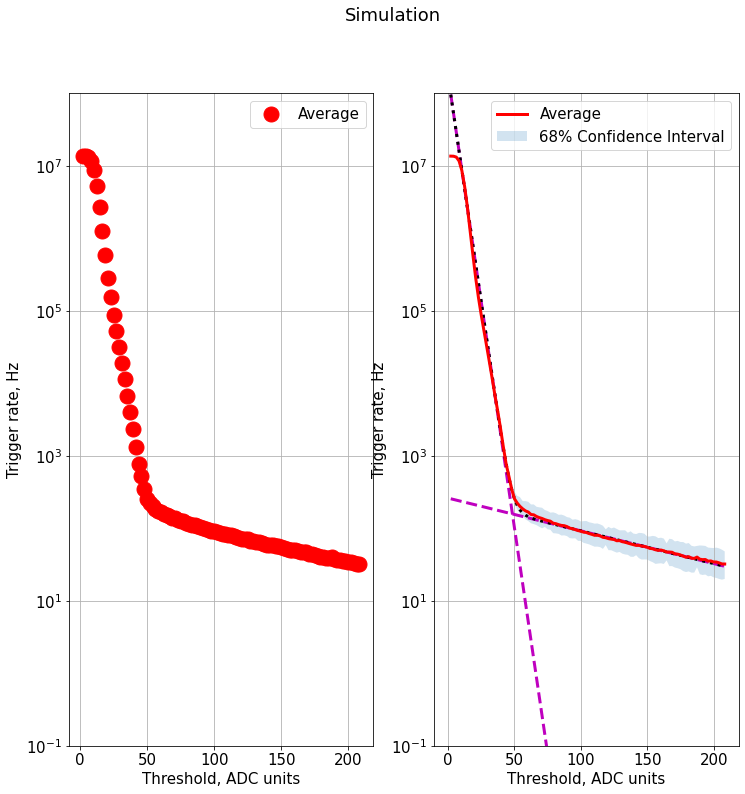

In [61]:
std_dev = np.array([a - b for a, b in zip(total_per_sector_rate_mc_up,total_per_sector_rate_mc)])
plot_per_sector_rates_1(sim_proton_sector_df['threshold'], np.array(total_per_sector_rate_mc),
                        np.array(total_per_sector_rate_mc_up),
                        np.array(total_per_sector_rate_mc_down), 'Simulation')

In [62]:
mc_average_intersection_point = 51.78619685430906
data_recalibrated_to_mc = recalibrate(clean_data, fit_results_data['Intersection'], mc_average_intersection_point)

shift maxes 7, 27


In [63]:
data_recalibrated_to_mc

(DAC1, 2)  (DAC1, 3)  (DAC1, 4)  (DAC1, 5)  (DAC1, 6)  (DAC1, 7)  \
0     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
1     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
2     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
3     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
4     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
..        ...        ...        ...        ...        ...        ...   
87       10.0        4.0       23.0       16.0       13.0       13.0   
88        9.0        4.0       30.0       15.0       14.0       16.0   
89       10.0        7.0       25.0       21.0       15.0       16.0   
90       10.0        6.0       23.0       17.0       11.0        8.0   
91        5.0       11.0       21.0       11.0       16.0       14.0   

    (DAC1, 10)  (DAC1, 11)  (DAC1, 12)  (DAC1, 13)  ...  (DAC2, 244)  \
0      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
1      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
2      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
3      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
4      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
..         ...         ...         ...         ...  ...          ...   
87        14.0        19.0         5.0        25.0  ...         14.0   
88        15.0        29.0        10.0        28.0  ...         11.0   
89        17.0        30.0         9.0        17.0  ...         15.0   
90        14.0        24.0         7.0        20.0  ...          5.0   
91        15.0        25.0        11.0        22.0  ...         13.0   

    (DAC2, 245)  (DAC2, 249)  (DAC2, 250)  (DAC2, 251)  (DAC2, 252)  \
0       65535.0      65535.0      65535.0      65535.0      65535.0   
1       65535.0      65535.0      65535.0      65535.0      65535.0   
2       65535.0      65535.0      65535.0      65535.0      65535.0   
3       65535.0      65535.0      65535.0      65535.0      65535.0   
4       65535.0      65535.0      65535.0      65535.0      65535.0   
..          ...          ...          ...          ...          ...   
87         15.0         16.0         21.0         26.0         12.0   
88         19.0         21.0         29.0         20.0         13.0   
89         13.0         13.0         20.0         20.0          8.0   
90         14.0         18.0         25.0         25.0         11.0   
91         17.0         12.0         26.0         24.0         12.0   

    (DAC2, 253)  (DAC2, 254)  (DAC2, 255)  threshold  
0       65535.0      65535.0      65535.0       14.0  
1       65535.0      65535.0      65535.0       16.0  
2       65535.0      65535.0      65535.0       18.0  
3       65535.0      65535.0      65535.0       20.0  
4       65535.0      65535.0      65535.0       22.0  
..          ...          ...          ...        ...  
87         10.0         21.0         19.0      188.0  
88         22.0         25.0         24.0      190.0  
89         12.0         27.0         16.0      192.0  
90         13.0         18.0         20.0      194.0  
91         17.0         26.0         21.0      196.0  

[92 rows x 455 columns]

In [64]:
def overlay_rates_data_mc_1(threshold, clean_data, sector_average_mc, sector_average_mc_high, sector_average_mc_low, title):
    sector_average_data = clean_data.mean(axis=1)

    std_deviation_data = clean_data.std(axis=1)

    fit_results_data = fit_trigger_rate_two_exp(sector_average_data, threshold)
    fit_results_mc = fit_trigger_rate_two_exp(sector_average_mc, threshold)

    fig, ax = plt.subplots(1,2)
    # plot trigger rates for each module and their average
    ax[0].semilogy(threshold, sector_average_data, marker='1', label = "Data")
    ax[0].semilogy(threshold, sector_average_mc, marker='2', label = "Simulation")
   
    ax[0].semilogy(threshold, sum_exp(threshold, *fit_results_data[1:5]), 
                         'k:', label = "Fit to data")
    ax[0].semilogy(threshold, sum_exp(threshold, *fit_results_mc[1:5]),
                         'm:', label = "Fit to simulation")
    #ax[1].semilogy(threshold, sector_average_data, marker='o', color='k', label = "Data")
    #ax[1].semilogy(threshold, sector_average_mc, marker='o', color='r', label = "Simulation")
    ax[1].semilogy(threshold, sector_average_data, 'k-', label = "Data")
    ax[1].semilogy(threshold, sector_average_mc, 'k-.', label = "Simulation")
    ax[1].fill_between(threshold,
                       sector_average_data - std_deviation_data,
                       sector_average_data + std_deviation_data,
                       color = 'yellow',
                       edgecolor = 'black',
                       linestyle ='-',
                       label = '68% Confidence Interval, Data')
    ax[1].fill_between(threshold,
                       sector_average_mc_low,
                       sector_average_mc_high,
                       color = 'lawngreen',
                       edgecolor = 'black',
                       linestyle ='-.',
                       alpha = 0.5,
                       label = '68% Confidence Interval, Simulation')
        
    for axis in ax:
        axis.set_xlabel('Threshold, [mV]')
        axis.set_xlim(100, 1000)
        axis.set_ylabel('Trigger rate, Hz')
        axis.set_ylim((pow(10,0),pow(10,5)))
        axis.grid(True)
        axis.legend()

    fig.suptitle(title)
    plt.show()

/home/voutsi/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/voutsi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


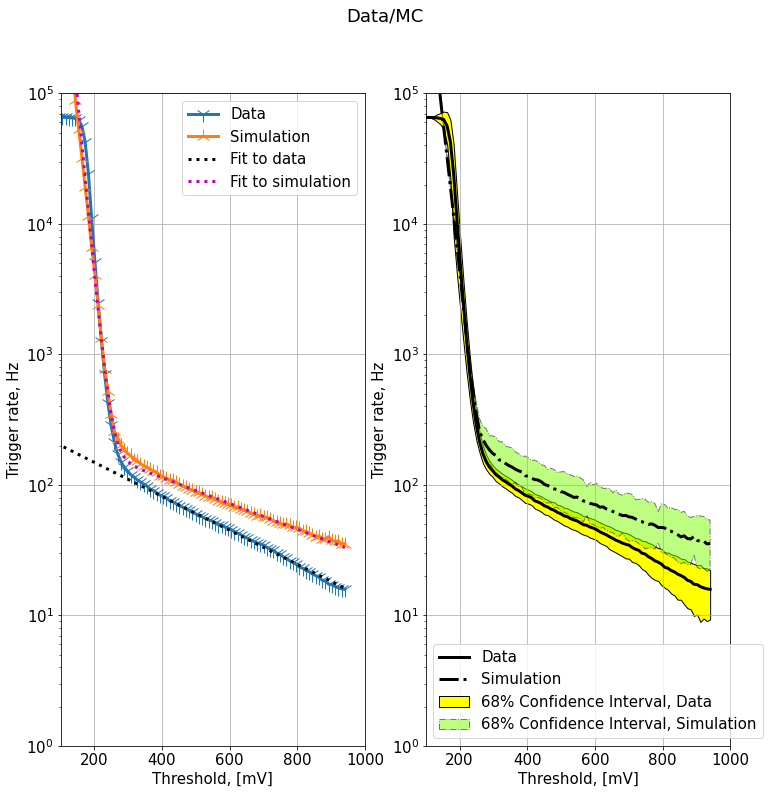

In [65]:
overlay_rates_data_mc_1(data_recalibrated_to_mc['threshold'] * 4.8,
                        data_recalibrated_to_mc.drop('threshold', axis=1, inplace=False),
                        np.array(total_per_sector_rate_mc)[3:95],
                        np.array(total_per_sector_rate_mc_up)[3:95],
                        np.array(total_per_sector_rate_mc_down)[3:95], 'Data/MC')

(0.1, 10000000)

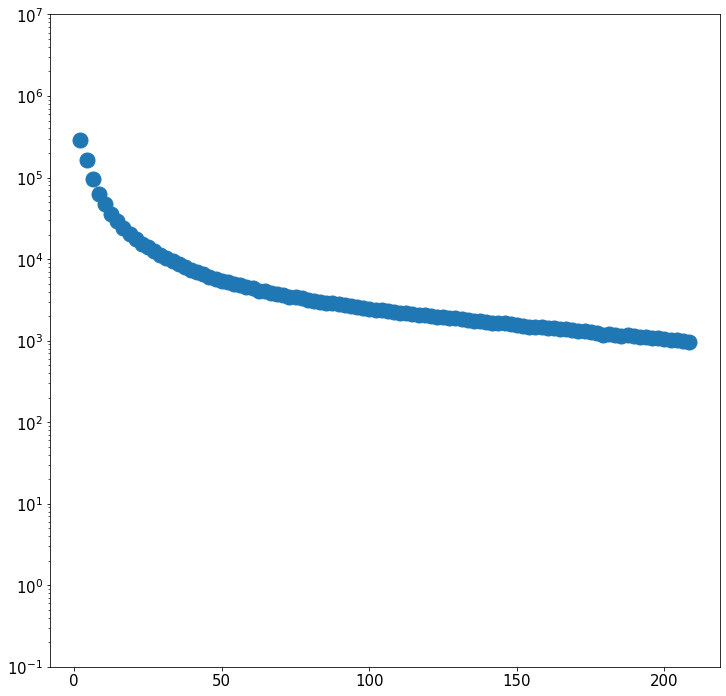

In [66]:
import glob
thresholds = []
rates = []
points = []
for i in sorted(glob.glob(f'/home/voutsi/tmp/threshold_rates/rate_threshold*.txt')):
    with open(i, 'r') as f:
        vals = f.readline().split(' ')
        thresholds.append(int(vals[1][:-1])/4.8)
        rates.append(float(vals[4]))
        points.append((int(vals[1][:-1])/4.8, float(vals[4])))

#plt.plot(thresholds, rates, 'bo', linestyle='None', markersize = 3.0)
plt.scatter(*zip(*points))
plt.yscale('log')
plt.ylim(0.1, 10**7)

In [67]:
def overlay_rates_data_mc_2(threshold, clean_data, sector_average_mc, sector_average_mc_high, sector_average_mc_low, reweighted_mc, title):
    sector_average_data = clean_data.mean(axis=1)

    std_deviation_data = clean_data.std(axis=1)

    fit_results_data = fit_trigger_rate_two_exp(sector_average_data, threshold)
    fit_results_mc = fit_trigger_rate_two_exp(sector_average_mc, threshold)

    fig, ax = plt.subplots(1,2)
    # plot trigger rates for each module and their average
    ax[0].semilogy(threshold, sector_average_data, marker='1', label = "Data")
    ax[0].semilogy(threshold, sector_average_mc, marker='2', label = "Simulation")
   
    ax[0].semilogy(threshold, sum_exp(threshold, *fit_results_data[1:5]), 
                         'k:', label = "Fit to data")
    ax[0].semilogy(threshold, sum_exp(threshold, *fit_results_mc[1:5]),
                         'm:', label = "Fit to simulation")
    #ax[1].semilogy(threshold, sector_average_data, marker='o', color='k', label = "Data")
    #ax[1].semilogy(threshold, sector_average_mc, marker='o', color='r', label = "Simulation")
    ax[1].semilogy(threshold, sector_average_data, 'k-', label = "Data")
    ax[1].semilogy(threshold, sector_average_mc, 'k-.', label = "Simulation")
    ax[1].fill_between(threshold,
                       sector_average_data - std_deviation_data,
                       sector_average_data + std_deviation_data,
                       color = 'yellow',
                       edgecolor = 'black',
                       linestyle ='-',
                       label = '68% Confidence Interval, Data')
    ax[1].fill_between(threshold,
                       sector_average_mc_low,
                       sector_average_mc_high,
                       color = 'lawngreen',
                       edgecolor = 'black',
                       linestyle ='-.',
                       alpha = 0.5,
                       label = '68% Confidence Interval, Simulation')
    
    ax[1].semilogy(threshold, reweighted_mc, 'r-.', label = "Reweighted simulation")
    
    for axis in ax:
        axis.set_xlabel('Threshold, [mV]')
        axis.set_xlim(100, 1000)
        axis.set_ylabel('Trigger rate, Hz')
        axis.set_ylim((pow(10,0),pow(10,5)))
        axis.grid(True)
        axis.legend()

    fig.suptitle(title)
    plt.show()

In [68]:
reweighted_proton_camera_rate = [_[1] for _ in sorted(points)]
reweighted_mc_camera_rate = [n + p * 1.5 for n, p in zip(nsb_camera_rate, reweighted_proton_camera_rate)]
reweighted_proton_camera_sector_rate = [a * b for a,b in zip(reweighted_proton_camera_rate, sim_proton_sector_df['Relative sector rate'])]
reweighted_per_sector_rate_mc = [n + p for n, p in zip(average_nsb_sector, reweighted_proton_camera_sector_rate)]

In [69]:
def overlay_rates_data_mc_3(threshold, clean_data, sector_average_mc, sector_average_mc_high, sector_average_mc_low, title, label_data="Data", label_mc="Simulation"):
    
    sector_average_data = clean_data.mean(axis=1)
    std_deviation_data = clean_data.std(axis=1)
    
    ratio = sector_average_data/sector_average_mc
    ratio_yerr_rel = np.sqrt(
                            (std_deviation_data/sector_average_data)**2 +
                            ((sector_average_mc_high - sector_average_mc_low)/(2*sector_average_mc))**2
                            )

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 12))
    
    # plot trigger rates for each module and their average

    ax[0].semilogy(threshold, sector_average_data, 'k-', label = label_data)
    ax[0].semilogy(threshold, sector_average_mc, 'k-.', label = label_mc)
    ax[0].fill_between(threshold,
                       sector_average_data - std_deviation_data,
                       sector_average_data + std_deviation_data,
                       color = 'yellow',
                       edgecolor = 'black',
                       linestyle ='-',
                       label = '68% Confidence Interval, Data')
    ax[0].fill_between(threshold,
                       sector_average_mc_low,
                       sector_average_mc_high,
                       color = 'lawngreen',
                       edgecolor = 'black',
                       linestyle ='-.',
                       alpha = 0.5,
                       label = '68% Confidence Interval, Simulation')
        

    
    ax[0].set_xlim(100, 1000)
    ax[0].set_ylabel('Trigger rate, Hz')
    ax[0].set_ylim((pow(10,0),pow(10,5)))
    ax[0].grid(True)
    ax[0].legend()
    
    ax[1].errorbar(threshold, ratio, yerr=ratio_yerr_rel * ratio, fmt='ko', capsize=5)
    ax[1].set_ylabel('Data/MC')
    ax[1].set_ylim(0.5, 1.5)
    ax[1].yaxis.set_ticks(np.arange(0.6, 1.4, 0.2))
    ax[1].grid(True)
    ax[1].axhline(y=1, linewidth=4, color='r')
    fig.subplots_adjust(hspace=0)
    ax[1].set_xlabel('Threshold, [mV]')

    fig.suptitle(title)
    plt.show()

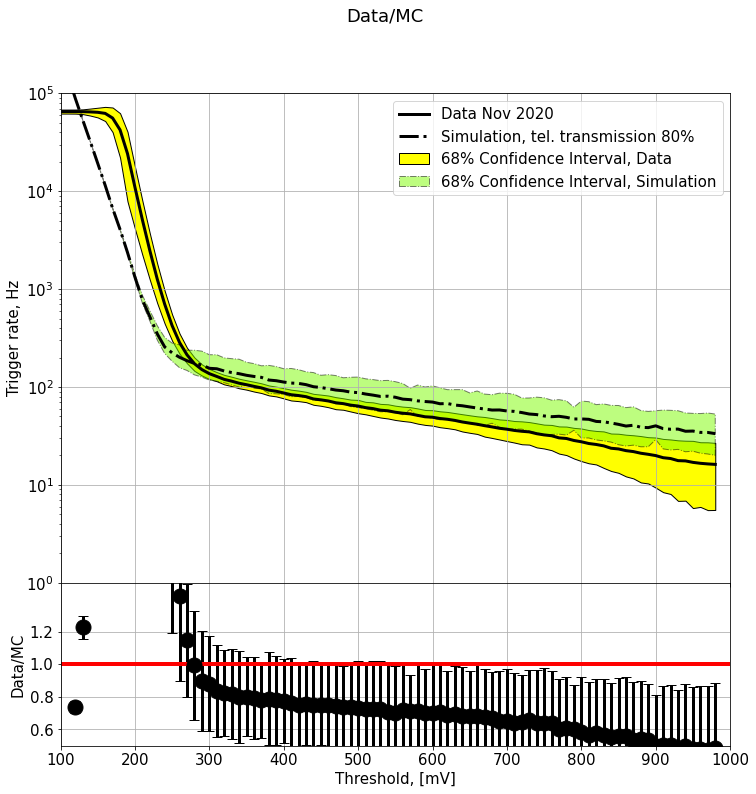

In [70]:
overlay_rates_data_mc_3(sim_proton_sector_df['threshold'][6:98] * 4.8,
                        data_recalibrated_to_mc,
                        np.array(total_per_sector_rate_mc)[6:98],
                        np.array(total_per_sector_rate_mc_up)[6:98],
                        np.array(total_per_sector_rate_mc_down)[6:98], 
                        'Data/MC',
                        'Data Nov 2020',
                        'Simulation, tel. transmission 80%')

In [71]:
def overlay_rates_data_mc_4(threshold, sector_average_mc, sector_average_mc_high, sector_average_mc_low, reweighted_mc, title):

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 12))
    ax[0].semilogy(threshold, sector_average_mc, 'k-.', label = "Interpolated simulation")
    
    ax[0].fill_between(threshold,
                       sector_average_mc_low,
                       sector_average_mc_high,
                       color = 'lawngreen',
                       edgecolor = 'black',
                       linestyle ='-.',
                       alpha = 0.5,
                       label = '68% Confidence Interval, interpolated simulation')
    
    ax[0].semilogy(threshold, reweighted_mc, 'r-.', label = "Reweighted simulation")
    
    ax[0].set_xlim(100, 1000)
    ax[0].set_ylabel('Trigger rate, Hz')
    ax[0].set_ylim((pow(10,0),pow(10,5)))
    ax[0].grid(True)
    ax[0].legend()
    
    ratio = sector_average_mc/reweighted_mc
    ratio_yerr_rel = (sector_average_mc_high - sector_average_mc_low)/(2*sector_average_mc)
    
    ax[1].errorbar(threshold, ratio, yerr=ratio_yerr_rel * ratio, fmt='ko', capsize=5)
    ax[1].set_ylabel('SimInter/SimReweight')
    ax[1].set_ylim(0.5, 1.5)
    ax[1].yaxis.set_ticks(np.arange(0.6, 1.4, 0.2))
    ax[1].grid(True)
    ax[1].axhline(y=1, linewidth=4, color='r')
    fig.subplots_adjust(hspace=0)
    ax[1].set_xlabel('Threshold, [mV]')
    

    fig.suptitle(title)
    plt.show()

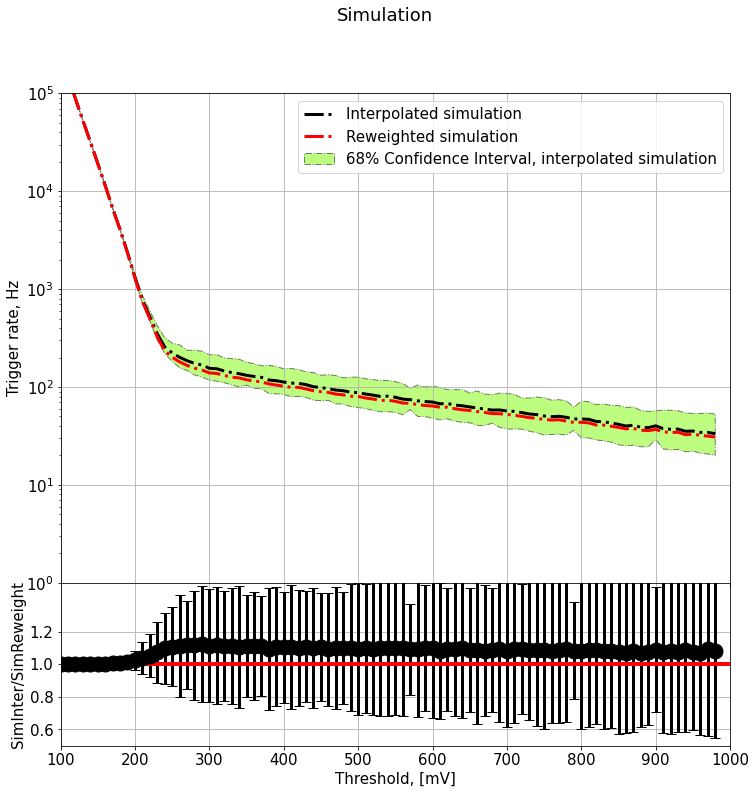

In [72]:
overlay_rates_data_mc_4(sim_proton_sector_df['threshold'][6:98] * 4.8,
                        np.array(total_per_sector_rate_mc)[6:98],
                        np.array(total_per_sector_rate_mc_up)[6:98],
                        np.array(total_per_sector_rate_mc_down)[6:98],
                        np.array(reweighted_per_sector_rate_mc)[6:98], 'Simulation')

In [73]:
def overlay_rates_data_mc_5(threshold, clean_data, sector_average_mc, sector_average_mc_high, sector_average_mc_low, title, label_data="Data", label_mc="Simulation"):
    
    sector_average_data = clean_data.mean(axis=1)
    std_deviation_data = clean_data.std(axis=1)
    
    ratio = sector_average_data/sector_average_mc
    ratio_yerr_rel = np.sqrt(
                            (std_deviation_data/sector_average_data)**2 +
                            ((sector_average_mc_high - sector_average_mc_low)/(2*sector_average_mc))**2
                            )

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # plot trigger rates for each module and their average

    ax.semilogy(threshold, sector_average_data, 'k-', label = label_data)
    ax.semilogy(threshold, sector_average_mc, 'k-.', label = label_mc)
    ax.fill_between(threshold,
                    sector_average_data - std_deviation_data,
                    sector_average_data + std_deviation_data,
                    color = 'yellow',
                    edgecolor = 'black',
                    linestyle ='-',
                    label = '68% Confidence Interval, Data')
    ax.fill_between(threshold,
                    sector_average_mc_low,
                    sector_average_mc_high,
                    color = 'lawngreen',
                    edgecolor = 'black',
                    linestyle ='-.',
                    alpha = 0.5,
                    label = '68% Confidence Interval, Simulation')
        

    
    ax.set_xlim(100, 1000)
    ax.set_xlabel('Threshold, [mV]')
    ax.set_ylabel('Trigger rate, Hz')
    ax.set_ylim((pow(10,0),pow(10,5)))
    ax.grid(True)
    ax.legend()

    fig.suptitle(title)
    plt.show()

In [74]:
sim_proton_sector_df

threshold  Camera triggered  Average sector triggered  \
0     2.083333             73281               2738.094937   
12    4.166667             43986               1347.219409   
23    6.250000             28013                826.742616   
34    8.333333             19857                582.531646   
45   10.416667             15103                444.584388   
..         ...               ...                       ...   
96  200.000000               663                 20.253165   
97  202.083333               659                 20.132911   
98  204.166667               655                 19.930380   
99  206.250000               650                 19.525316   
2   208.333333               627                 19.299578   

    Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0                91.201644              0.037364                 0.038609   
12               47.326302              0.030628                 0.031704   
23               34.525860              0.029513                 0.030745   
34               24.133508              0.029336                 0.030552   
45               21.262630              0.029437                 0.030845   
..                     ...                   ...                      ...   
96                4.284606              0.030548                 0.037010   
97                4.227853              0.030551                 0.036966   
98                4.257211              0.030428                 0.036928   
99                4.011112              0.030039                 0.036210   
2                 4.138800              0.030781                 0.037382   

    Relative sector rate down  
0                    0.036120  
12                   0.029552  
23                   0.028280  
34                   0.028121  
45                   0.028029  
..                        ...  
96                   0.024085  
97                   0.024135  
98                   0.023929  
99                   0.023868  
2                    0.024180  

[100 rows x 7 columns]

In [75]:
sim_proton_sector_df['Threshold in pe'] = sim_proton_sector_df['threshold']/2.15 

In [76]:
sim_proton_sector_df['Threshold in mV'] = sim_proton_sector_df['threshold']*4.8  

In [77]:
sim_proton_sector_df

threshold  Camera triggered  Average sector triggered  \
0     2.083333             73281               2738.094937   
12    4.166667             43986               1347.219409   
23    6.250000             28013                826.742616   
34    8.333333             19857                582.531646   
45   10.416667             15103                444.584388   
..         ...               ...                       ...   
96  200.000000               663                 20.253165   
97  202.083333               659                 20.132911   
98  204.166667               655                 19.930380   
99  206.250000               650                 19.525316   
2   208.333333               627                 19.299578   

    Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0                91.201644              0.037364                 0.038609   
12               47.326302              0.030628                 0.031704   
23               34.525860              0.029513                 0.030745   
34               24.133508              0.029336                 0.030552   
45               21.262630              0.029437                 0.030845   
..                     ...                   ...                      ...   
96                4.284606              0.030548                 0.037010   
97                4.227853              0.030551                 0.036966   
98                4.257211              0.030428                 0.036928   
99                4.011112              0.030039                 0.036210   
2                 4.138800              0.030781                 0.037382   

    Relative sector rate down  Threshold in pe  Threshold in mV  
0                    0.036120         0.968992             10.0  
12                   0.029552         1.937984             20.0  
23                   0.028280         2.906977             30.0  
34                   0.028121         3.875969             40.0  
45                   0.028029         4.844961             50.0  
..                        ...              ...              ...  
96                   0.024085        93.023256            960.0  
97                   0.024135        93.992248            970.0  
98                   0.023929        94.961240            980.0  
99                   0.023868        95.930233            990.0  
2                    0.024180        96.899225           1000.0  

[100 rows x 9 columns]

In [78]:
combined_df = sim_proton_sector_df

In [79]:
combined_df['sim sector rate vs threshold in mV'] = np.array(total_per_sector_rate_mc)
combined_df['sim sector rate vs threshold in mV, up'] = np.array(total_per_sector_rate_mc_up)
combined_df['sim sector rate vs threshold in mV, down'] = np.array(total_per_sector_rate_mc_down)

In [80]:
combined_df['Threshold in pe, sim'] = combined_df['Threshold in mV'] / 6.5

In [81]:
combined_df

threshold  Camera triggered  Average sector triggered  \
0     2.083333             73281               2738.094937   
12    4.166667             43986               1347.219409   
23    6.250000             28013                826.742616   
34    8.333333             19857                582.531646   
45   10.416667             15103                444.584388   
..         ...               ...                       ...   
96  200.000000               663                 20.253165   
97  202.083333               659                 20.132911   
98  204.166667               655                 19.930380   
99  206.250000               650                 19.525316   
2   208.333333               627                 19.299578   

    Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0                91.201644              0.037364                 0.038609   
12               47.326302              0.030628                 0.031704   
23               34.525860              0.029513                 0.030745   
34               24.133508              0.029336                 0.030552   
45               21.262630              0.029437                 0.030845   
..                     ...                   ...                      ...   
96                4.284606              0.030548                 0.037010   
97                4.227853              0.030551                 0.036966   
98                4.257211              0.030428                 0.036928   
99                4.011112              0.030039                 0.036210   
2                 4.138800              0.030781                 0.037382   

    Relative sector rate down  Threshold in pe  Threshold in mV  \
0                    0.036120         0.968992             10.0   
12                   0.029552         1.937984             20.0   
23                   0.028280         2.906977             30.0   
34                   0.028121         3.875969             40.0   
45                   0.028029         4.844961             50.0   
..                        ...              ...              ...   
96                   0.024085        93.023256            960.0   
97                   0.024135        93.992248            970.0   
98                   0.023929        94.961240            980.0   
99                   0.023868        95.930233            990.0   
2                    0.024180        96.899225           1000.0   

    sim sector rate vs threshold in mV  \
0                         1.366565e+07   
12                        1.362358e+07   
23                        1.325089e+07   
34                        1.171220e+07   
45                        8.665321e+06   
..                                 ...   
96                        3.438009e+01   
97                        3.432884e+01   
98                        3.339425e+01   
99                        3.227847e+01   
2                         3.220960e+01   

    sim sector rate vs threshold in mV, up  \
0                             1.366877e+07   
12                            1.362521e+07   
23                            1.325206e+07   
34                            1.171259e+07   
45                            8.665664e+06   
..                                     ...   
96                            5.355840e+01   
97                            5.424599e+01   
98                            5.294166e+01   
99                            5.076122e+01   
2                             4.814482e+01   

    sim sector rate vs threshold in mV, down  Threshold in pe, sim  
0                               1.366412e+07              1.538462  
12                              1.362266e+07              3.076923  
23                              1.325001e+07              4.615385  
34                              1.171194e+07              6.153846  
45                              8.665109e+06              7.692308  
..                                       ...              

In [82]:
combined_df['data sector rate'] = np.nan
combined_df['data sector rate'][3:95] = data_recalibrated_to_mc.mean(axis=1)
combined_df['data sector rate std dev'] = np.nan
combined_df['data sector rate std dev'][3:95] = data_recalibrated_to_mc.std(axis=1)

/tmp/ipykernel_23175/3319653678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['data sector rate'][3:95] = data_recalibrated_to_mc.mean(axis=1)
/tmp/ipykernel_23175/3319653678.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['data sector rate std dev'][3:95] = data_recalibrated_to_mc.std(axis=1)


In [83]:
combined_df

threshold  Camera triggered  Average sector triggered  \
0     2.083333             73281               2738.094937   
12    4.166667             43986               1347.219409   
23    6.250000             28013                826.742616   
34    8.333333             19857                582.531646   
45   10.416667             15103                444.584388   
..         ...               ...                       ...   
96  200.000000               663                 20.253165   
97  202.083333               659                 20.132911   
98  204.166667               655                 19.930380   
99  206.250000               650                 19.525316   
2   208.333333               627                 19.299578   

    Sigma sector triggered  Relative sector rate  Relative sector rate up  \
0                91.201644              0.037364                 0.038609   
12               47.326302              0.030628                 0.031704   
23               34.525860              0.029513                 0.030745   
34               24.133508              0.029336                 0.030552   
45               21.262630              0.029437                 0.030845   
..                     ...                   ...                      ...   
96                4.284606              0.030548                 0.037010   
97                4.227853              0.030551                 0.036966   
98                4.257211              0.030428                 0.036928   
99                4.011112              0.030039                 0.036210   
2                 4.138800              0.030781                 0.037382   

    Relative sector rate down  Threshold in pe  Threshold in mV  \
0                    0.036120         0.968992             10.0   
12                   0.029552         1.937984             20.0   
23                   0.028280         2.906977             30.0   
34                   0.028121         3.875969             40.0   
45                   0.028029         4.844961             50.0   
..                        ...              ...              ...   
96                   0.024085        93.023256            960.0   
97                   0.024135        93.992248            970.0   
98                   0.023929        94.961240            980.0   
99                   0.023868        95.930233            990.0   
2                    0.024180        96.899225           1000.0   

    sim sector rate vs threshold in mV  \
0                         1.366565e+07   
12                        1.362358e+07   
23                        1.325089e+07   
34                        1.171220e+07   
45                        8.665321e+06   
..                                 ...   
96                        3.438009e+01   
97                        3.432884e+01   
98                        3.339425e+01   
99                        3.227847e+01   
2                         3.220960e+01   

    sim sector rate vs threshold in mV, up  \
0                             1.366877e+07   
12                            1.362521e+07   
23                            1.325206e+07   
34                            1.171259e+07   
45                            8.665664e+06   
..                                     ...   
96                            5.355840e+01   
97                            5.424599e+01   
98                            5.294166e+01   
99                            5.076122e+01   
2                             4.814482e+01   

    sim sector rate vs threshold in mV, down  Threshold in pe, sim  \
0                               1.366412e+07              1.538462   
12                              1.362266e+07              3.076923   
23                              1.325001e+07              4.615385   
34                              1.171194e+07              6.153846   
45                              8.665109e+06              7.692308   
..                                       ...        

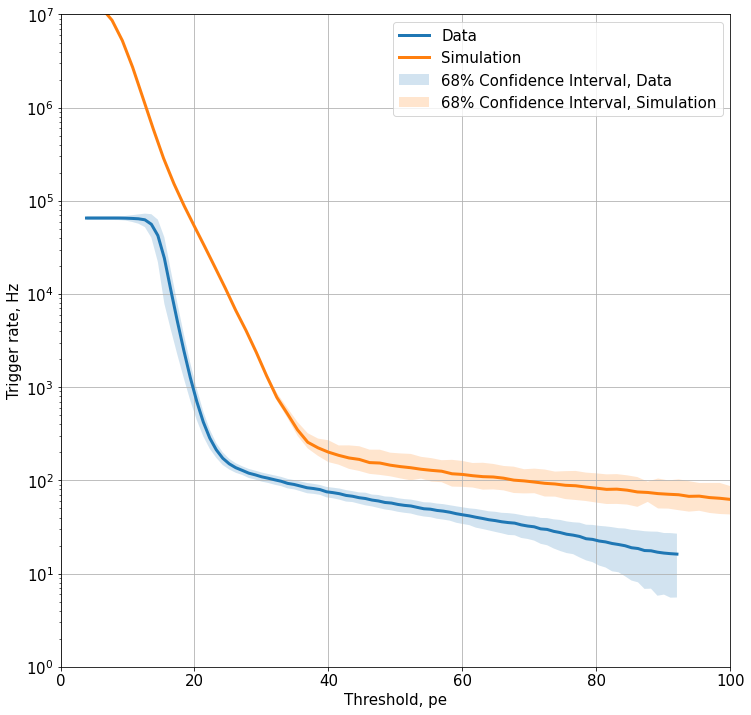

In [84]:
plt.semilogy(combined_df['Threshold in pe'], combined_df['data sector rate'], label='Data')
plt.semilogy(combined_df['Threshold in pe, sim'], combined_df['sim sector rate vs threshold in mV'], label='Simulation')
plt.fill_between(combined_df['Threshold in pe'],
                 combined_df['data sector rate']-combined_df['data sector rate std dev'],
                 combined_df['data sector rate']+combined_df['data sector rate std dev'],
                 alpha=0.2, label='68% Confidence Interval, Data')
plt.fill_between(combined_df['Threshold in pe, sim'],
                 combined_df['sim sector rate vs threshold in mV, down'],
                 combined_df['sim sector rate vs threshold in mV, up'],
                 alpha=0.2, label='68% Confidence Interval, Simulation')
plt.xlim(0, 100)
plt.xlabel('Threshold, pe')
plt.ylabel('Trigger rate, Hz')
plt.ylim((pow(10,0),pow(10,7)))
plt.semilogy()
plt.legend()
plt.grid(True)


In [85]:
data = clean_data.drop('threshold', axis=1).copy()
data[('threshold', 'ADC units')] = clean_data['threshold']
data[('threshold', 'mV')] = clean_data['threshold'] * 4.8
data[('threshold', 'pe')] = clean_data['threshold'] / 2.08
data.head(5)

DAC1                                                                 ...  \
       2      3      4      5      6      7     10     11     12     13  ...   
0  65535  65535  65535  65535  65535  65535  65535  65535  65535  65535  ...   
1  65535  65535  65535  65535  65535  65535  65535  65535  65535  65535  ...   
2  65535  65535  65535  65535  65535  65535  65535  65535  65535  65535  ...   
3  65535  65535  65535  65535  65535  65535  65535  65535  65535  65535  ...   
4  65535  65535  65535  65535  65535  65535  65535  65535  65535  65535  ...   

    DAC2                                           threshold                  
     249    250    251    252    253    254    255 ADC units    mV        pe  
0  65535  65535  65535  65535  65535  65535  65535         0   0.0  0.000000  
1  65535  65535  65535  65535  65535  65535  65535         2   9.6  0.961538  
2  65535  65535  65535  65535  65535  65535  65535         4  19.2  1.923077  
3  65535  65535  65535  65535  65535  65535  65535         6  28.8  2.884615  
4  65535  65535  65535  65535  65535  65535  65535         8  38.4  3.846154  

[5 rows x 457 columns]

In [86]:
simulation = pd.DataFrame({('threshold', 'mV') : np.arange(10, 1010, 10)})
simulation[('threshold', 'ADC units')] = simulation[('threshold', 'mV')]/4.8
simulation[('threshold', 'pe')] =simulation[('threshold', 'mV')]/6.5
simulation['rate'] = np.array(total_per_sector_rate_mc)
simulation['rate_err_up'] = np.array(total_per_sector_rate_mc_up)
simulation['rate_err_down'] = np.array(total_per_sector_rate_mc_down)

In [87]:
simulation.tail()

threshold                               rate rate_err_up rate_err_down
          mV   ADC units          pe                                     
95       960  200.000000  147.692308  34.380093   53.558396     21.076333
96       970  202.083333  149.230769  34.328843   54.245993     20.675517
97       980  204.166667  150.769231  33.394254   52.941656     20.059210
98       990  206.250000  152.307692  32.278474   50.761217     19.598561
99      1000  208.333333  153.846154  32.209600   48.144819     20.046536

Average fit results:  (35.81357796774817, -0.3887, 18.98344, -0.01408, 5.56703, 0.01071, 0.00013)


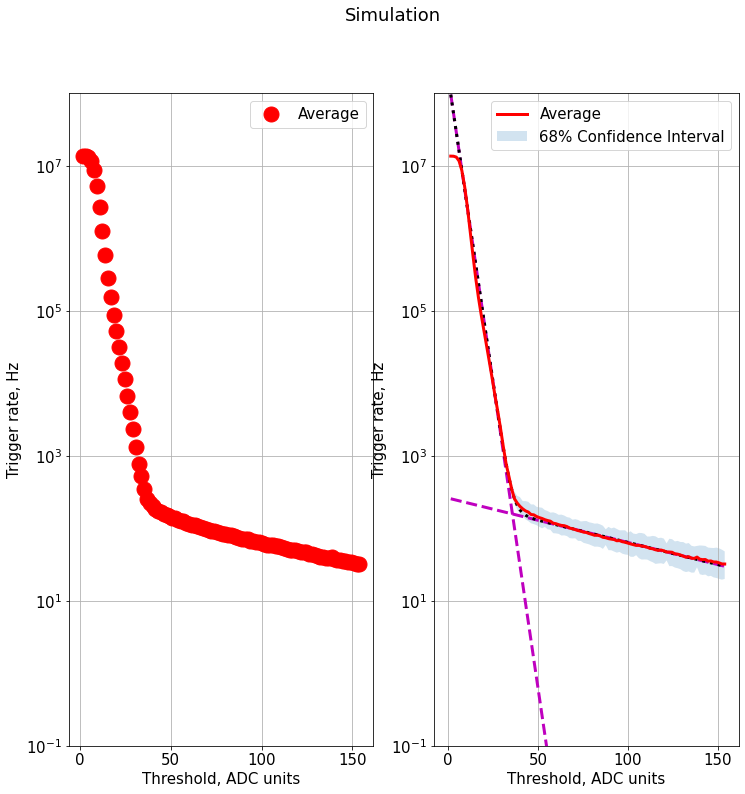

In [88]:
plot_per_sector_rates_1(simulation[('threshold', 'pe')],
                        simulation['rate'],
                        simulation['rate_err_up'],
                        simulation['rate_err_down'], 'Simulation')

In [89]:
fit_results_data = get_fit_results(data.drop('threshold', axis=1, inplace=False),
                                                data[('threshold', 'pe')])
tmp_data = data.drop('threshold', axis=1, inplace=False)
tmp_data['threshold'] = data[('threshold', 'pe')]
recalibrated_data = recalibrate(tmp_data, fit_results_data['Intersection'], 38.242115144226666)
fit_results_data_recalibrated = get_fit_results(recalibrated_data.drop('threshold', axis=1, inplace=False),
                                                recalibrated_data['threshold'])

shift maxes 21, 13


In [90]:
recalibrated_data['average'] = recalibrated_data.drop('threshold', axis=1).mean(axis=1)
recalibrated_data['std_dev'] = recalibrated_data.drop('threshold', axis=1).std(axis=1)
recalibrated_data

(DAC1, 2)  (DAC1, 3)  (DAC1, 4)  (DAC1, 5)  (DAC1, 6)  (DAC1, 7)  \
0     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
1     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
2     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
3     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
4     65535.0    65535.0    65535.0    65535.0    65535.0    65535.0   
..        ...        ...        ...        ...        ...        ...   
87       10.0        4.0       23.0       16.0       13.0       13.0   
88        9.0        4.0       30.0       15.0       14.0       16.0   
89       10.0        7.0       25.0       21.0       15.0       16.0   
90       10.0        6.0       23.0       17.0       11.0        8.0   
91        5.0       11.0       21.0       11.0       16.0       14.0   

    (DAC1, 10)  (DAC1, 11)  (DAC1, 12)  (DAC1, 13)  ...  (DAC2, 249)  \
0      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
1      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
2      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
3      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
4      65535.0     65535.0     65535.0     65535.0  ...      65535.0   
..         ...         ...         ...         ...  ...          ...   
87        14.0        19.0         5.0        25.0  ...         16.0   
88        15.0        29.0        10.0        28.0  ...         21.0   
89        17.0        30.0         9.0        17.0  ...         13.0   
90        14.0        24.0         7.0        20.0  ...         18.0   
91        15.0        25.0        11.0        22.0  ...         12.0   

    (DAC2, 250)  (DAC2, 251)  (DAC2, 252)  (DAC2, 253)  (DAC2, 254)  \
0       65535.0      65535.0      65535.0      65535.0      65535.0   
1       65535.0      65535.0      65535.0      65535.0      65535.0   
2       65535.0      65535.0      65535.0      65535.0      65535.0   
3       65535.0      65535.0      65535.0      65535.0      65535.0   
4       65535.0      65535.0      65535.0      65535.0      65535.0   
..          ...          ...          ...          ...          ...   
87         21.0         26.0         12.0         10.0         21.0   
88         29.0         20.0         13.0         22.0         25.0   
89         20.0         20.0          8.0         12.0         27.0   
90         25.0         25.0         11.0         13.0         18.0   
91         26.0         24.0         12.0         17.0         26.0   

    (DAC2, 255)   threshold       average   std_dev  
0       65535.0   20.192308  65535.000000  0.000000  
1       65535.0   21.153846  65535.000000  0.000000  
2       65535.0   22.115385  65535.000000  0.000000  
3       65535.0   23.076923  65535.000000  0.000000  
4       65535.0   24.038462  65535.000000  0.000000  
..          ...         ...           ...       ...  
87         19.0  103.846154     17.202643  7.072525  
88         24.0  104.807692     16.601322  7.690150  
89         16.0  105.769231     16.226872  6.764710  
90         20.0  106.730769     15.980176  6.934054  
91         21.0  107.692308     15.795154  6.484809  

[92 rows x 457 columns]

In [91]:
interpolated_simulation = interpolate_mc(simulation.drop('threshold', axis=1, inplace=False), simulation[('threshold', 'pe')], recalibrated_data['threshold'])
interpolated_simulation.columns

Index([('rate', ''), ('rate_err_up', ''), ('rate_err_down', '')], dtype='object')

In [92]:
combined_df = pd.DataFrame({('threshold', 'pe') : recalibrated_data['threshold'],
                            ('data', 'average') : recalibrated_data['average'],
                            ('data', 'std_dev') : recalibrated_data['std_dev'],
                            ('mc', 'rate') : interpolated_simulation[('rate', '')],
                            ('mc', 'rate_err_up') : interpolated_simulation[('rate_err_up','')],
                            ('mc', 'rate_err_down') : interpolated_simulation[('rate_err_down', '')],
                           }
)

In [93]:
combined_df

threshold          data                      mc                \
            pe       average   std_dev          rate   rate_err_up   
0    20.192308  65535.000000  0.000000  50538.340652  50662.266908   
1    21.153846  65535.000000  0.000000  37432.167490  37562.271672   
2    22.115385  65535.000000  0.000000  27359.249360  27490.335129   
3    23.076923  65535.000000  0.000000  19308.501252  19437.104379   
4    24.038462  65535.000000  0.000000  14441.178071  14547.405540   
..         ...           ...       ...           ...           ...   
87  103.846154     17.202643  7.072525     58.865050     84.073211   
88  104.807692     16.601322  7.690150     58.175726     83.830499   
89  105.769231     16.226872  6.764710     58.253804     85.785828   
90  106.730769     15.980176  6.934054     57.771859     86.422600   
91  107.692308     15.795154  6.484809     56.916564     86.180334   

                  
   rate_err_down  
0   50470.091102  
1   37354.856112  
2   27278.408558  
3   19227.819296  
4   14372.101195  
..           ...  
87     41.529978  
88     42.143719  
89     39.723356  
90     38.150342  
91     37.142227  

[92 rows x 6 columns]

In [96]:
def overlay_rates_data_mc_6(threshold, sector_average_data, std_deviation_data, sector_average_mc, sector_average_mc_high, sector_average_mc_low, title, label_data="Data", label_mc="Simulation"):
    
    ratio = sector_average_data/sector_average_mc
    ratio_yerr_rel = np.sqrt(
                            (std_deviation_data/sector_average_data)**2 +
                            ((sector_average_mc_high - sector_average_mc_low)/(2*sector_average_mc))**2
                            )

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12, 12))
    
    # plot trigger rates for each module and their average

    ax[0].semilogy(threshold, sector_average_data, 'k-', label = label_data)
    ax[0].semilogy(threshold, sector_average_mc, 'k-.', label = label_mc)
    ax[0].fill_between(threshold,
                       sector_average_data - std_deviation_data,
                       sector_average_data + std_deviation_data,
                       color = 'yellow',
                       edgecolor = 'black',
                       linestyle ='-',
                       label = '68% Confidence Interval, Data')
    ax[0].fill_between(threshold,
                       sector_average_mc_low,
                       sector_average_mc_high,
                       color = 'lawngreen',
                       edgecolor = 'black',
                       linestyle ='-.',
                       alpha = 0.5,
                       label = '68% Confidence Interval, Simulation')
        

    
    ax[0].set_xlim(20, 120)
    ax[0].set_ylabel('Trigger rate, Hz')
    ax[0].set_ylim((pow(10,0),pow(10,5)))
    ax[0].grid(True)
    ax[0].legend()
    
    ax[1].errorbar(threshold, ratio, yerr=ratio_yerr_rel * ratio, fmt='ko', capsize=5)
    ax[1].set_ylabel('Data/MC')
    ax[1].set_ylim(0.5, 1.5)
    ax[1].yaxis.set_ticks(np.arange(0.2, 1.4, 0.2))
    ax[1].grid(True)
    ax[1].axhline(y=1, linewidth=4, color='r')
    fig.subplots_adjust(hspace=0)
    ax[1].set_xlabel('Threshold, [pe]')

    fig.suptitle(title)
    plt.show()

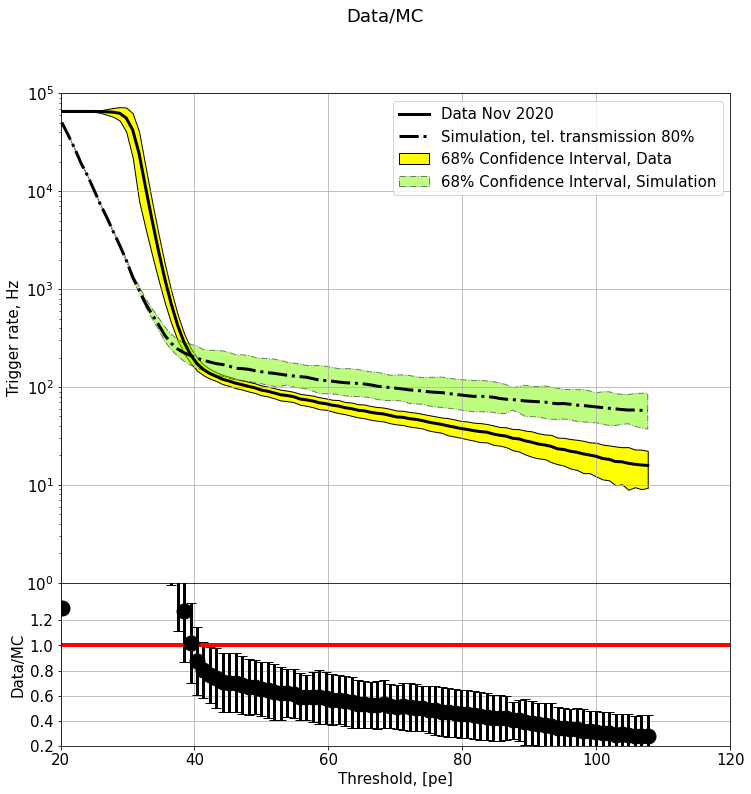

In [97]:
overlay_rates_data_mc_6(combined_df[('threshold', 'pe')],
                        combined_df[('data', 'average')],
                        combined_df[('data', 'std_dev')],
                        combined_df[('mc', 'rate')],
                        combined_df[('mc', 'rate_err_up')],
                        combined_df[('mc', 'rate_err_down')], 
                        'Data/MC',
                        'Data Nov 2020',
                        'Simulation, tel. transmission 80%')

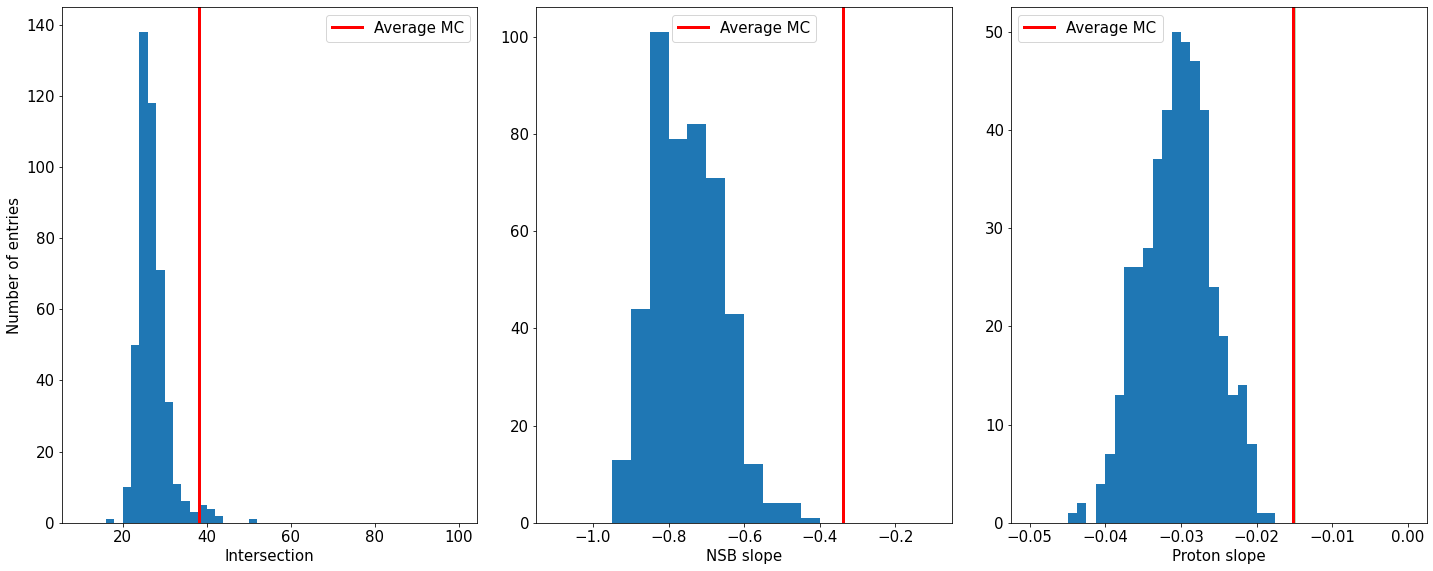

In [98]:
plot_fit_parameters_with_overlay(fit_results_data, 38.242115144226666, -0.33949, -0.01513, 0.002, 0.00023)

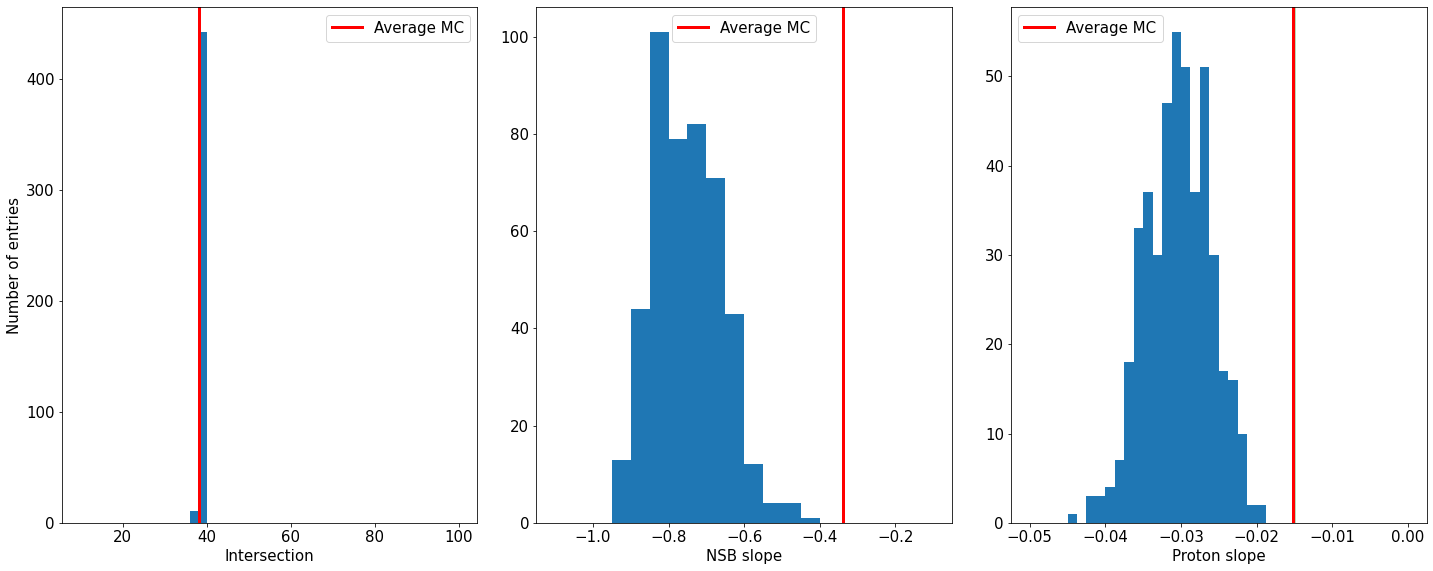

In [99]:
plot_fit_parameters_with_overlay(fit_results_data_recalibrated, 38.242115144226666, -0.33949, -0.01513, 0.002, 0.00023)